In [1]:
#--- extract the catalog

import pandas as pd
#import matplotlib; matplotlib.use('agg')
import sys
from matplotlib import rc
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from matplotlib import patches
import warnings
import matplotlib.ticker
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import datetime
import path
from math import *
import matplotlib.dates as mdates
from matplotlib import dates
import matplotlib.dates as md
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import itertools
import traceback
from scipy.ndimage import gaussian_filter
import math

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
#--- add a new time attribute
def ConvertTime( df_in ):
    df=df_in.copy()
    df.insert(0,'date',pd.to_datetime(swarm[['year', 'month', 'day', 'hour', 'minute', 'second']]))
    df.drop(['year', 'month', 'day', 'hour', 'minute', 'second'],axis=1,inplace=True)
    return df

#--- set path
SWARM_PATH = './dataset/RidgeCrest/DataS1_noXYZ.txt' #sys.argv[1]
DIR_OUTPT = './dataset/RidgeCrest' #sys.argv[2]
DIR_OUTPT_figs = '/Users/Home/Desktop/Tmp/txt' #'/Users/Home/Dropbox/Documents/papers/microSeismicityOklahoma/figs'

#--- store
swarm = pd.read_csv( SWARM_PATH, sep = ',' ) #--- parse data

swarm = ConvertTime( swarm ) #--- add new column 'date'

#--- sort based on time
swarm.sort_values(by=['date'],inplace=True)

#--- reindex
swarm.reset_index(inplace=True,drop=True)

#--- rename cols
swarm = swarm.rename(index=str,columns={'lat':'latitude','lon':'longitude','mag':'magnitude'})

swarm.head()

,date,latitude,longitude,depth,magnitude,ID
0,2019-07-04 15:35:29.400,35.708036,-117.499365,12.527,0.17,70456129
1,2019-07-04 15:42:47.900,35.708040,-117.499382,12.508,0.59,70456568
2,2019-07-04 16:07:19.950,35.708081,-117.499430,12.517,0.50,70458040
3,2019-07-04 16:13:11.390,35.707955,-117.499211,12.506,0.04,70458391
4,2019-07-04 16:13:43.160,35.708044,-117.499382,12.495,1.50,70458423


In [2]:
#--- remove nan

swarm = swarm.dropna(subset=['magnitude'])
swarm.info()


<class 'pandas.core.frame.DataFrame'>
Index: 34091 entries, 0 to 34090
Data columns (total 6 columns):
date         34091 non-null datetime64[ns]
latitude     34091 non-null float64
longitude    34091 non-null float64
depth        34091 non-null float64
magnitude    34091 non-null float64
ID           34091 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.8+ MB


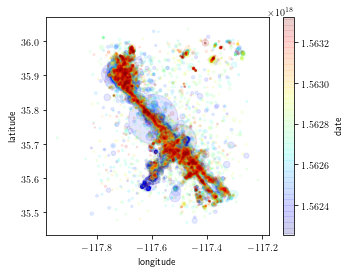

<Figure size 432x288 with 0 Axes>

In [3]:
#--- plot spatial map 
#--- fault map california: temporal evolution of events


def DataFrameSubSet( df, column, (xmin,xmax) ):
    return df[ ( df[column] >= xmin ) & 
               ( df[column] < xmax ) ]

#--- subset of data
swarm_lohi = swarm.copy()#DataFrameSubSet( swarm, 
                          #   'date', 
                           #  ( pd.to_datetime('2010-04-04'), pd.to_datetime('2010-06-26') ) )

swarm_lohi.plot.scatter('longitude','latitude',
                        s=3**(swarm_lohi['magnitude']),
                        c='date',cmap='jet',
                        alpha=0.1,figsize=(5,4)) #--- plot

# swarm_lohi.plot.scatter('longitude','depth',
#                         s=3**(swarm_lohi['magnitude']),
#                         c='date',cmap='jet',
#                         alpha=0.1,figsize=(5,4)) #--- plot

# swarm_lohi.plot.scatter('latitude','depth',
#                         s=3**(swarm_lohi['magnitude']),
#                         c='date',cmap='jet',
#                         alpha=0.1,figsize=(5,4)) #--- plot

plt.show()
plt.savefig('%s/map.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')

#plt.figure(figsize=(6,6)).gca(projection='3d')
#plt.xlabel('Long')
#plt.ylabel('Lat')
#plt.scatter(swarm_lohi['longitude'],
 #           swarm_lohi['latitude'],
  #          swarm_lohi['depth']) #s=10*swarm['magnitude'],cmap='jet') #--- plot


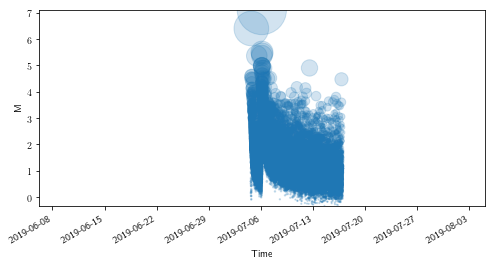

In [4]:
#--- plot timeseries


class Tlohi:
    def __init__(self,lo,hi):
        self.lo = lo
        self.hi = hi

fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
plt.xlabel('Time')
plt.ylabel('M')

plt.ylim(swarm['magnitude'].min(),swarm['magnitude'].max())

tt=swarm[swarm['magnitude']==swarm['magnitude'].sort_values(ascending=False).iloc[3]]['date']
plt.xlim(tt-datetime.timedelta(days=30),tt+datetime.timedelta(days=30))# pd.to_datetime('2014-12-04'),pd.to_datetime('2015-06-1'))
#plt.xlim(swarm['date'].min(),pd.to_datetime('2010-07-20'))
plt.scatter(swarm['date'],swarm['magnitude'],
            s=2*np.exp(swarm['magnitude']),
            alpha=0.2)

#myTlohi = Tlohi( pd.to_datetime('2010-04-08'), 
#                 pd.to_datetime('2010-07-01'))

#plt.plot([myTlohi.lo,myTlohi.lo],
#        [-2,7],'r-')

#plt.plot([myTlohi.hi,myTlohi.hi],
#        [-2,7],'r-')
fig.autofmt_xdate()
plt.savefig('%s/timeSeries.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')
plt.show()


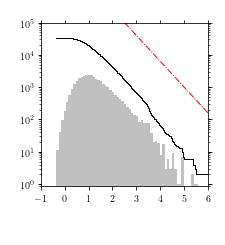

In [5]:
#--- freq-magnitude relation

import sys 

def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = d.keys()
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, xrange( sys.maxint ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict





#--- set min/max time to avoid temporal incompletenesss issue
swarm_copy = swarm.copy()#DataFrameSubSet( swarm, 
                          #   'date', 
                           #  ( myTlohi.lo, 
                            #   myTlohi.hi ) )
#--- accumulated histogram
N = len(swarm_copy['magnitude'])
slist=np.array(swarm_copy['magnitude'])
slist.sort()
d = histogramACCUMLTD( slist.tolist() )
keys=d.keys()
keys.sort()

#--- plot
fig= plt.figure(figsize=(3,3))#,dpi=150)
ax = fig.add_subplot(111)

ax.axis([-1,6,.9,1e5])
ax.set_yscale('log')

#--- add major xticks
xmin=np.ceil(ax.axis()[0])
xmax=np.floor(ax.axis()[1])
nbin = xmax - xmin
ax.set_xticks(np.linspace(ax.axis()[0],ax.axis()[1],int(nbin)+1))

#--- add major yticks
ymin=np.ceil(np.log10(ax.axis()[2]))
ymax=np.floor(np.log10(ax.axis()[3]))
nbin = ymax - ymin
ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))

#--- put minor bins
#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#--- put minor bins y
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='y',left=True, right=True,which='both')
ax.tick_params(axis='x',bottom=True, top=True,which='both')


xmin=swarm_copy['magnitude'].min()
xmax=swarm_copy['magnitude'].max()
dx=0.1
junk = ax.hist( swarm_copy['magnitude'],
                bins=int((xmax-xmin)/dx),
               label='histogram',color='silver') #--- histogram
xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(N-d[ikey][2])
ax.plot(xx,yy,
            linestyle='-', drawstyle='steps-post',color='black',
             linewidth=1.0) #--- accumulated
    
b=0.8
ax.plot([2.5,6],[1e5, 1e5* 10**(-b*(6-2.5))],'r-.',linewidth=1)

DrawFrame(ax, (0.2,0.06),(0.32,0.1),0.01,LOG_Y=True) 

plt.savefig('%s/gr.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')#,transparent=True)
plt.show()


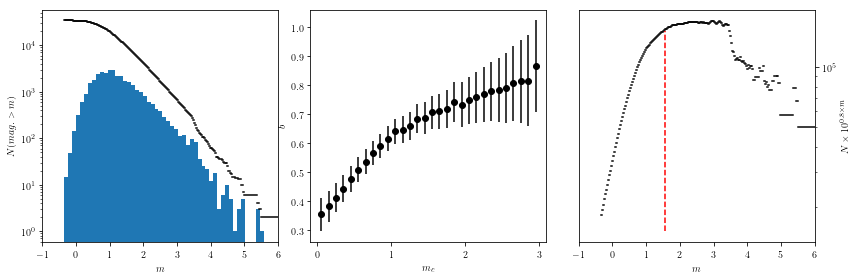

In [6]:
#--- estimate b by varying the mc value

from math import *
import scipy.stats

#--- set min/max time to avoid temporal incompletenesss issue
swarm_copy = swarm.copy()#DataFrameSubSet( swarm.copy()#, 
                          #   'date', #
                           #  ( myTlohi.#lo, 
                            #   myTlohi.hi# ) )

#--- plot distributions (Nm)
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(131)
ax.set_xlabel('$m$')
ax.set_ylabel('$N(mag.>m)$')
xmin = -1 #np.floor(swarm_copy['magnitude'].min())
xmax = 6 #np.ceil(swarm_copy['magnitude'].min())
ax.set_xticks(np.linspace(xmin,xmax,int(xmax-xmin)/1+1))
ax.set_xlim(xmin,xmax)
#plt.ylim(1,1e5)
ax.set_yscale('log')
for ikey in keys:
    ax.plot([d[ikey][0],d[ikey][1]],
             [N-d[ikey][2],N-d[ikey][2]],
             '-',color='black') #--- accumulated
junk = ax.hist( swarm_copy['magnitude'],
                bins=64,
               label='histogram') #--- histogram

#--- list of magnitudes
mm_list = swarm_copy['magnitude'].to_list()
mm_list = np.sort(mm_list)

#--- b vs mc
ax2=fig.add_subplot(132)
ax2.set_xticks(np.linspace(-1.0,3.0,5))
#ax2.set_ylim(0,1.8)
#ax4 = ax2.twinx()
#ax4.set_yscale('log')
#ax4.set_ylim(1e-16,)
#plt.xlim(0.0,1.5)
ax2.set_xlabel('$m_c$')
ax2.set_ylabel('$b$')
#ax4.set_ylabel(r'$p_{val}$',labelpad=-70)

#--- bvalue bhatacharya eq. 5
DM = 0.1
n = 30
#--- 
MC = []
B = []
Err_B = []
pval = []
for mc_new in [0.05+i*0.1 for i in xrange(n)]: #--- m values are quantized (+- 0.1)!
    mlist = swarm_copy[ swarm_copy['magnitude']-mc_new>=0.0]['magnitude'] 
    m_mean=mlist.mean()
    assert m_mean-mc_new > 0.0, 'm_mean=%s,mc=%s'%( m_mean, mc )
    k_mean = (m_mean-mc_new)/DM
    b_value = log(np.exp(1),10)*log(1+DM/(m_mean-mc_new))/DM
    nsamp = len(mlist)
#    err_b = 1.96*(b_value/nsamp/log(10,exp(1.0)))**0.5
    err_b = 2*(k_mean*(k_mean+1)/nsamp)**0.5/log(10,exp(1.0)) #--- Guttorp and Hopkins (1986) eq.(4)

    
    
#     #--- bvalue bhatacharya eq. 6
#     #--- accumulated histogram
#     slist = mm_list[ mm_list>=mc_new ]
#     slist.sort()
#     NN = len(slist)
#     cdf = histogramACCUMLTD( slist.tolist() )
#     #--- bvalue bhatacharya eq. 6
#     n_cdf=len(cdf)-1
#     bi = []
#     for i in xrange(n_cdf):
#         mi = cdf[ i ][ 0 ]
#         Ni = NN - cdf[ i ][ 2 ]
#         bij = []
#         for j in xrange(n_cdf):
#             mj = cdf[ j ][ 0 ]
#             Nj = NN - cdf[ j ][ 2 ]
#             if i == j: continue
#             slope = ( log( Nj, 10 ) - log( Ni, 10 ) ) / ( mj - mi )
#             assert not np.isnan(slope)
#             bij.append( slope )
#         bi.append( np.median( bij ) )
#     bval_2nd = -np.median( bi )
#     err_b2nd = np.std(bi)/(len(bi))**0.5
    
    #--- plot b vs mc
    ax2.errorbar([mc_new],[b_value],yerr=err_b,marker='o',color='black')
#    ax2.errorbar([mc_new],[bval_2nd],yerr=err_b2nd, marker='o',color='red')
    
    #---
    MC.append(mc_new)
    B.append(b_value)
    Err_B.append(err_b)

    #--- p-value (by hand)
#    (dmax,pval2nd) = scipy.stats.kstest( mlist, lambda x: 1.0-10**(-b_value*(x-mc_new)))
#    ax4.plot([mc_new],[pval2nd],marker='o',color='red')
#    pval.append(pval2nd)

#--- choose the range of mc
mc_range=[1.5,1.5]
index_tf = [i and j for i, j in zip(mc_range[0]<=np.array(MC),np.array(MC)<mc_range[1])]
bvall =  np.array(B)[index_tf]
Err_B =  np.array(Err_B)[index_tf]

#--- b vs mc: vertical lines
#ax2.plot([mc_range[0],mc_range[0]],[np.min(B),np.max(B)],'--r')    
#ax2.plot([mc_range[1],mc_range[1]],[np.min(B),np.max(B)],'--r')    

#--- N vs m: vertical line
#ax.plot([mc_range[0]+DM/2,mc_range[0]+DM/2],
 #       [1,len(swarm_copy['magnitude'])],'--r')    

#--- n*10*bm (rescaled)
bval=0.8 #np.mean(bvall)
#bval2=0.8
ax3=fig.add_subplot(133)
ax3.set_xlabel('$m$')
#ax3.set_ylabel(r'$N\times10^{%s\times m}$'%bval)
ax3.set_ylabel(r'$N\times10^{%s\times m}$'%bval)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_yscale('log')
ax3.set_xticks(np.linspace(xmin,xmax,int(xmax-xmin)/1+1))
ax3.set_xlim(xmin,xmax)
#ax3.set_ylim(1e3,1e6)
#ax3.set_xticks(np.linspace(ax3.axis()[0],ax3.axis()[1],4))
for ikey in keys: #--- rescaled
    c = 10**(bval*d[ikey][0])
    ax3.plot([d[ikey][0],d[ikey][1]],
             [c*(N-d[ikey][2]),c*(N-d[ikey][2])],'-',color='black',
            ) #--- accumulated
#     c = 10**(bval2*d[ikey][0])
#     ax3.plot([d[ikey][0],d[ikey][1]],
#              [c*(N-d[ikey][2]),c*(N-d[ikey][2])],'-',color='red',
#              ) #--- accumulated
ax3.plot([mc_range[0]+DM/2,mc_range[0]+DM/2], #--- vertical line
        [len(swarm_copy[swarm_copy['magnitude']>mc_range[0]])*10**(bval*mc_range[0])/10,
         len(swarm_copy[swarm_copy['magnitude']>mc_range[0]])*10**(bval*mc_range[0])],'--r')    
#plt.plot(MC, pval,'-o',color='black')

fig.tight_layout(w_pad=-0.5)
fig.savefig('%s/b.png'%DIR_OUTPT_figs,dpi=75)
plt.show()


In [7]:
##--- estimate b and mc
#
#
#with path.Path('/Users/Home/Desktop/Tmp/txt/myPYlibs'):
#    import plfit
#    import plvar
#    import plpva
#
##--- set min/max time to avoid temporal incompletenesss issue
#swarm_copy = swarm.copy()#DataFrameSubSet( swarm, 
#                          #   'date', 
#                           #  ( myTlohi.lo, 
#                            #   myTlohi.hi ) )
#
##--- power law fit clauset
#n_samp = 1000
#n_chunk = len( swarm_copy ) / n_samp
#
#i = 0
#fig = plt.figure(figsize=(8,4))
#ax = fig.add_subplot(111)
#ax.set_ylabel('m')
#ax2=ax.twinx()
#ax.scatter(swarm_copy['date'],swarm_copy['magnitude'],
#          alpha=0.1)
#
#fig2 = plt.figure(figsize=(8,4))
#ax21 = fig2.add_subplot(111)
#ax21.set_ylabel('m')
#ax21.scatter(swarm_copy['date'],swarm_copy['magnitude'],
#          alpha=0.1)
#
#MC = []
#B = []
#for j in xrange(n_chunk):
#    Mlist = 10**(swarm_copy.iloc[i:i+n_samp]['magnitude'])
#    fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#    mc = log(fit[1],10) #--- completeness mag.
#    bval = fit[0]-1
#    MC.append(mc)
#    B.append(bval)
##    print mc, bval
#    ax2.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [bval,bval],'-',color='red')
#
#    ax21.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [mc,mc],'-',color='red')
#
#    i += n_samp
#Mlist = 10**(swarm_copy.iloc[i:i+len(swarm_copy)%n_samp]['magnitude'])
#fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#mc = log(fit[1],10) #--- completeness mag.
#bval = fit[0]-1
#MC.append(mc)
#B.append(bval)
#
##---- plot bval
#ax2.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [bval,bval],'-',color='red')
#ax2.tick_params(colors='red')
#ax2.set_ylabel('b',color='red')
#ax.set_xlabel('Date')
##print mc, bval
#fig.savefig('%s/b.png'%DIR_OUTPT_figs,dpi=75)
##--- plot mc
#ax21.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [mc,mc],'-',color='red',label='mc')
#plt.legend()
#ax21.set_xlabel('Date')
#
##n, bins, patches = plt.hist(B, 50)
#
##--- error estimate
##[ error_b, error_mc, ntail ] = [ 0.0, 0.0, 0.0 ]
##[error_b, error_mc, ntail] = plvar.plvar(np.array(Mlist), 'silent')
##error_mc = log(1.0+error_mc/fit[1],10) #--- log(1+dM/M)
#plt.savefig('%s/mc.png'%DIR_OUTPT_figs,dpi=75)

In [8]:
# #--- goodness of the fit

# n_samp = 1000
# n_chunk = len( swarm_copy ) / n_samp
# ncols=4
# nrows = n_chunk / ncols + int(np.ceil(1.0*( len(swarm_copy) % n_samp) / n_samp))
# i = 0
# plt.figure(figsize=(ncols*4,nrows*4))
# for j in xrange(n_chunk):
#     Mlist = 10**(swarm_copy.iloc[i:i+n_samp]['magnitude'])
#     fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#     mc = log(fit[1],10) #--- completeness mag.
#     bval = fit[0]-1
# #    [error_b, error_mc, ntail] = plvar.plvar(Mlist, 'silent') #--- error
#     plt.subplot(nrows,ncols,j+1)
#     Mlist=np.log10(Mlist)
#     nc = len(Mlist[Mlist>=mc])
#     error_b = (bval / nc / log(10.0) )**0.5
#     hist,bins = np.histogram(Mlist,bins=1024)
#     plt.plot(bins[:-1],-hist.cumsum()+len(Mlist))#,marker='o',markersize=6,linestyle='None')
#     xc=0.5*(bins[:-1]+bins[1:])
#     plt.plot(xc, len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r',label='$b=%2.1f\pm%3.2f$'%(bval,error_b))
#     plt.plot([mc,mc],[1,len(Mlist[Mlist>=mc])],label='$mc=%2.1f$'%(mc)) # len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r')
#     plt.yscale('log')
#     plt.xlim(swarm_copy['magnitude'].min(),swarm_copy['magnitude'].max())
#     plt.ylim(1,n_samp*10)
#     if j == 0:
#         plt.ylabel('N(size>m)')
#         plt.xlabel('m')
#     plt.legend()
#     i += n_samp

# Mlist = 10**(swarm_copy.iloc[i:i+len(swarm_copy)%n_samp]['magnitude'])
# fit = plfit.plfit( np.array(Mlist) ) #--- clauset
# mc = log(fit[1],10) #--- completeness mag.
# bval = fit[0]-1
# Mlist=np.log10(Mlist)
# nc = len(Mlist[Mlist>=mc])
# error_b = (bval / nc / log(10.0) )**0.5
# hist,bins = np.histogram(Mlist,bins=1024)

# plt.subplot(nrows,ncols,j+2)
# plt.plot(bins[:-1],-hist.cumsum()+len(Mlist))#,marker='o',markersize=6,linestyle='None')
# xc=0.5*(bins[:-1]+bins[1:])
# plt.plot(xc, len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r',label='$b=%2.1f\pm%3.2f$'%(bval,error_b))
# plt.plot([mc,mc],[1,len(Mlist[Mlist>=mc])],label='$m_c=%2.1f$'%(mc)) # len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r')
# plt.yscale('log')
# plt.xlim(swarm_copy['magnitude'].min(),swarm_copy['magnitude'].max())
# plt.ylim(1,n_samp)
# plt.legend()

# plt.savefig('%s/b_mult.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')
    

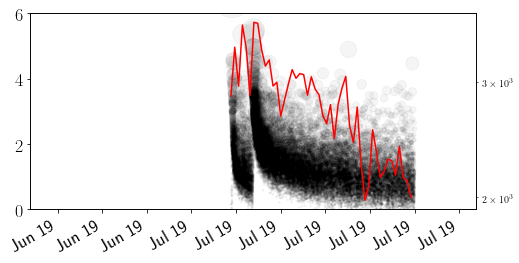

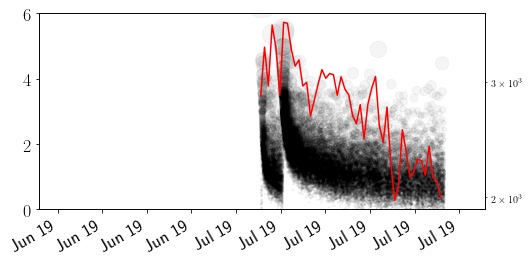

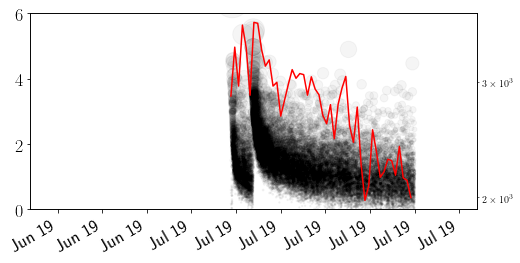

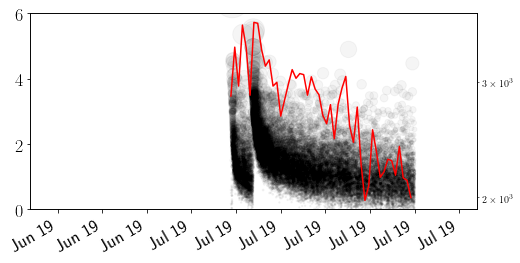

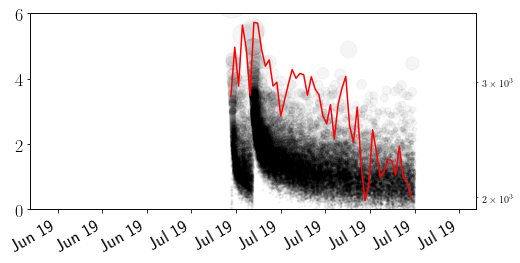

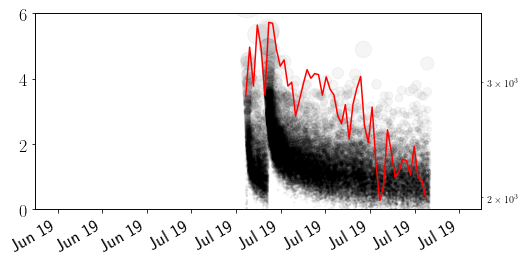

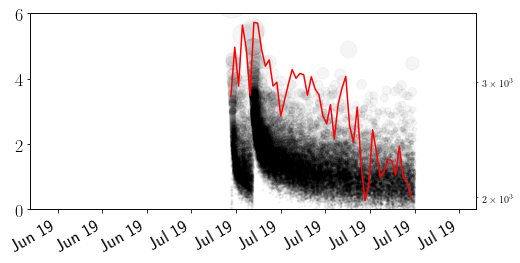

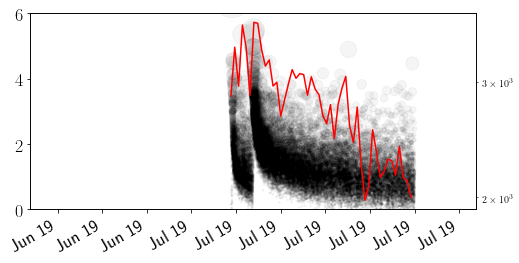

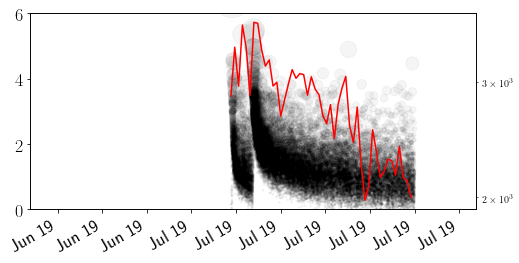

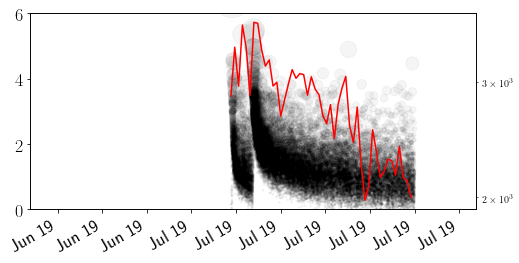

In [7]:
#--- plot complete catalog

def ConvertDailyRate(hist, bin_edges ):
#---convert data to daily rate     
    t0 = pd.to_datetime( bin_edges[ 0 ] )
    t1 = pd.to_datetime( bin_edges[ 1 ] )
    delta_t = ( t1 - t0 ).total_seconds() / ( 60 * 60*24)
    hist *= ( bin_edges[ 1 ] - bin_edges[ 0 ] ) / delta_t

def ActivityRate( swarm ):
    nbins = int( (swarm['date'].max()-swarm['date'].min()).days*4 ) #--- number of bins
    
    tmax = swarm['date'].max().value #--- min/max
    tmin = swarm['date'].min().value
    
    hist, bin_edges = np.histogram(swarm['date'].apply(lambda x:x.value),                                   
                    bins=np.linspace(tmin,tmax,nbins+1,endpoint=True),density=True) #--- probability dist.
    hist *= len( swarm['date'] ) #--- int(hist).dt=n
    cumm_number = np.cumsum(hist)*(bin_edges[1]-bin_edges[0]) #--- accumulated number
    ConvertDailyRate( hist, bin_edges ) #--- daily activity
    return bin_edges, hist, cumm_number
    
    
#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------
   
#--- completeness
mc = 1.5



#--- t0<t<t1
#--- set min/max time to avoid temporal incompletenesss issue
swarm_tmp = swarm.copy()#DataFrameSubSet( swarm, 
                         #    'date', 
                          #   ( swarm['date'].min(), 
                           #    pd.to_datetime('2010-07-31') ) )
#--- m > mc
swarm_lohi = swarm_tmp.copy() #DataFrameSubSet( swarm_tmp, 
                            # 'magnitude', 
                             #( mc, sys.maxint ) ) 

#--- spatial map
#swarm_lohi.plot.scatter('longitude','latitude',
#                        s=3**(swarm_lohi['magnitude']),
#                        c='date',cmap='jet',
#                        alpha = 0.4) #--- plot
    
#--- temporal map
#ax1.set_xlim(swarm_tmp['date'].min(),swarm_tmp['date'].max())
for ii in xrange(10):
    fig = plt.figure(figsize=(8,4))
    ax1=fig.add_subplot(111)

    #plt.xlabel('Time')
    #plt.ylabel('M')

    ax1.set_ylim(0,6)
    tt=swarm[swarm['magnitude']==swarm['magnitude'].sort_values(ascending=False).iloc[ii]]['date'].iloc[0]
    ax1.set_xlim(tt-datetime.timedelta(days=15),tt+datetime.timedelta(days=15))# pd.to_datetime('2014-12-04'),pd.to_datetime('2015-06-1'))
    
    ax1.tick_params(axis='both',labelsize=18)
    #ax1.tick_params(axis='x',rotation=18)
    
    ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
                s=2*np.exp(swarm_lohi['magnitude']),
                alpha=0.04,color='black')
        
    #--- activity rate
    bin_edges, hist, cumm_number = ActivityRate( swarm_lohi )
    
    #--- plot
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(pd.to_datetime(bin_edges[:-1]),hist,'r-')
    
    ax2.tick_params(axis='y',labelsize=18,colors='red')
    
    ax2.set_yscale('log')
    
    #ax2.set_ylim(1e1,1e3)
    
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%b %y'))
    
    fig.autofmt_xdate()

fig.savefig('%s/timeSeries_ok.png'%DIR_OUTPT_figs,bbox_inches='tight')
plt.show()


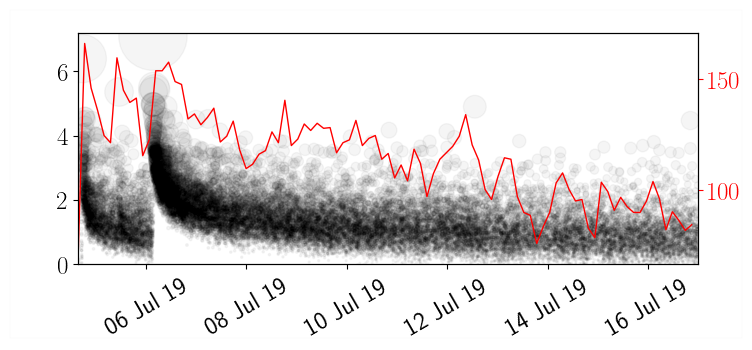

In [88]:
#--- plot complete catalog

def ConvertDailyRate(hist, bin_edges ):
#---convert data to daily rate     
    t0 = pd.to_datetime( bin_edges[ 0 ] )
    t1 = pd.to_datetime( bin_edges[ 1 ] )
    delta_t = ( t1 - t0 ).total_seconds() / ( 60 * 60 )
    hist *= ( bin_edges[ 1 ] - bin_edges[ 0 ] ) / delta_t

def ActivityRate( swarm ):
    nbins = int( (swarm['date'].max()-swarm['date'].min()).days * 8 ) #--- number of bins
    
    tmax = swarm['date'].max().value #--- min/max
    tmin = swarm['date'].min().value
    
    hist, bin_edges = np.histogram(swarm['date'].apply(lambda x:x.value),                                   
                    bins=np.linspace(tmin,tmax,nbins+1,endpoint=True),density=True) #--- probability dist.
    hist *= len( swarm['date'] ) #--- int(hist).dt=n
    cumm_number = np.cumsum(hist)*(bin_edges[1]-bin_edges[0]) #--- accumulated number
    ConvertDailyRate( hist, bin_edges ) #--- daily activity
    return bin_edges, hist, cumm_number
    
    
#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------
   
#--- completeness
mc = 1.5



#--- t0<t<t1
#--- set min/max time to avoid temporal incompletenesss issue
swarm_tmp = swarm.copy()#DataFrameSubSet( swarm, 
                         #    'date', 
                          #   ( swarm['date'].min(), 
                           #    pd.to_datetime('2010-07-31') ) )
#--- m > mc
swarm_lohi = swarm_tmp.copy() #DataFrameSubSet( swarm_tmp, 
                            # 'magnitude', 
                             #( mc, sys.maxint ) ) 

#--- spatial map
#swarm_lohi.plot.scatter('longitude','latitude',
#                        s=3**(swarm_lohi['magnitude']),
#                        c='date',cmap='jet',
#                        alpha = 0.4) #--- plot
    
#--- temporal map
fig = plt.figure(figsize=(8,3))#,dpi=150)
ax1=fig.add_subplot(111)

#plt.xlabel('Time')
#plt.ylabel('M')

ax1.set_ylim(0,7.2)
ax1.set_xlim(swarm_tmp['date'].min(),swarm_tmp['date'].max())

ax1.tick_params(axis='both',labelsize=18)
ax1.tick_params(axis='x',rotation=30)

ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
            s=2*np.exp(swarm_lohi['magnitude']),
            alpha=0.04,color='black')

DrawFrame(ax1, (0.11,0.07),(0.32,0.1),0.01)

#--- activity rate
bin_edges, hist, cumm_number = ActivityRate( swarm_lohi )

#--- plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(pd.to_datetime(bin_edges[:-1]),hist,'r-',linewidth=1)

ax2.tick_params(axis='y',labelsize=18,colors='red')

#ax2.set_yscale('log')

#ax2.set_ylim(1e1,3e2)

ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %b %y'))

#fig.autofmt_xdate(bottom=.1)

fig.savefig('%s/timeSeries_ok.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')
plt.show()


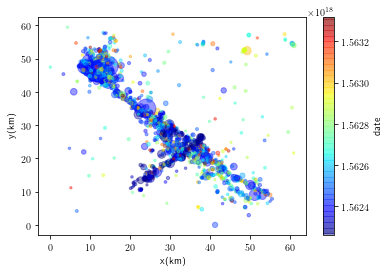

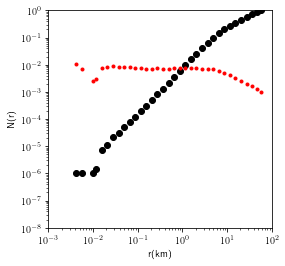

In [9]:
#--- evaluate fractal dimension

import geopy.distance
from math import *
import random as rnd

class bins:
    def __init__(self, nBin, xlo, xhi, ydim = 1, err = None):
        self.lo = xlo - 1.0e-10
        self.hi = xhi + 1.0e-10
        self.dx = (self.hi-self.lo)/nBin
        self.xlist = [0.0 for i in xrange(nBin)]
        self.kounter = [0 for i in xrange(nBin)]
        self.ylist = [[0.0 for j in xrange(ydim)] for i in xrange(nBin)]
        self.nBin = nBin
        self.err = err
        self.max_y = [[-sys.maxint for j in xrange(ydim)] for i in xrange(nBin) ]
        self.min_y = [[sys.maxint for j in xrange(ydim)] for i in xrange(nBin)]
        if err:
            self.ySQlist = [[0.0 for j in xrange(ydim)] for i in xrange(nBin)]
    def GetBin(self,x):
        return int(floor((x-self.lo)/self.dx))
    def whichBin(self,x,y, ibin=[] ):
        assert x >= self.lo, 'x=%s,self.lo=%s'%(10**x,10**self.lo)
        assert x < self.hi, 'x=%s,self.hi=%s'%(10**x,10**self.hi)
        nr = int(floor((x-self.lo)/self.dx))
        if ibin:
            ibin[ 0 ] = nr
        self.kounter[nr] += 1
        self.xlist[nr] += x
        for idim in xrange(len(y)):
            self.ylist[nr][idim] += y[idim]
            if y[idim] >= self.max_y[nr][idim]: #--- set max value
                self.max_y[nr][idim]=y[idim]
            if y[idim] <= self.min_y[nr][idim]:
                self.min_y[nr][idim]=y[idim]
            if self.err:
                self.ySQlist[nr][idim] += y[ idim ] * y[ idim ]

    def res(self, logScaleX = None, logScaleY = None, base = 10, SUM = None, MINMAX=None ):
         indices = xrange(10**6)
         someList = []
         for x,index in zip(self.xlist,indices):
             nb = self.kounter[index]
             if nb == 0: continue
             xbar = self.xlist[index]/nb
             ybar = [y/nb for y in self.ylist[index]]
             if self.err:
                 sigmaY = [ ( ysq / nb - YBAR * YBAR ) ** 0.5 / nb ** 0.5 for ysq, YBAR in zip( self.ySQlist[ index ], ybar )]
                 if SUM:
                     sigmaY = [ i * nb for i in sigmaY ]
             if SUM:
                 ybar = [y for y in self.ylist[index]]
             if MINMAX:
                 MAX_y = [y for y in self.max_y[index]]
             if logScaleX:
                 xbar = base ** xbar
             if logScaleY:
                 ybar = [ base ** item for item in ybar ]
             if self.err:
                 someList.append([ xbar, ybar, sigmaY ])
             elif MINMAX:
                 someList.append([ xbar, ybar, MAX_y ])
             else:
                 someList.append([ xbar, ybar ])
         return someList


class histogram( bins ):
    def res( self, Radial = None, logScale = None, normalize = True, base = 10.0, ACCUMLTD = None ):
        PDF = []
        self.nPoint = nPoint = sum( self.kounter )
        indices = xrange( sys.maxint )
        y_accm = nPoint
        for y, index in zip( self.kounter, indices ):
            if not ACCUMLTD and y == 0:
                continue
            if not y == 0:
                x = self.xlist[ index ] / y #self.lo + index * self.dx
            else:
                x = self.lo + index * self.dx
            Y = 1.0 * y
            dx = self.dx
            if logScale:
                x = base ** x
                dx = x * ( base ** self.dx - 1.0 )
#               print Y, dx
            if normalize:
                Y /= ( nPoint * dx )
                if Radial:
                    Y /= ( 2.0 * pi * x )
#           PDF.append( [ x, Y ] )
#           PDF.append( [ x + dx, Y ] )
#           PDF.append( [ x + 0.5 * dx, Y, 0.0, ( 1.0 * y_accm / nPoint if normalize else 1.0 * y_accm )  ] )
            error_std = 0.0
            if self.err:
                error_std = sqrt( nPoint * Y * dx ) / ( nPoint * dx ) #--- poisson
                error_std = sqrt( nPoint * Y * dx * ( 1.0 - Y * dx ) ) / ( nPoint * dx ) #--- bi-nomial
            PDF.append( [ x, Y, 0.0, ( 1.0 * y_accm / nPoint if normalize else 1.0 * y_accm ), error_std ] )
            y_accm -= y
        return PDF

def GetCartesian( dff ):
    df = dff.copy()
    xlo = df['longitude'].min()
    xhi = df['longitude'].max()
    ylo = df['latitude'].min()
    yhi = df['latitude'].max()
    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
    df[ 'x(km)' ] = df[ 'longitude' ].apply( getDistX ) 
    df[ 'y(km)' ] = df[ 'latitude' ].apply( getDistY ) 
    df[ 'z(km)' ] = df['depth']
    return df

def fractalDimension2nd( coord ):
    #--- sort
    if type( coord ) == type( [] ):
        coord = ListToDict( coord )
    points = coord.keys()
    points.sort()
    hsObject = histogram( 18 * 8, log( 1e-10,10), log( 1e8, 10 ) )
    for point_i in points:
        for point_j in points:
            if not point_i < point_j: #--- pairs ij with i<j
                continue
            rij = sum( [ ( i - j ) ** 2 for i, j in zip( coord[ point_i ], coord[ point_j ] ) ] ) # ** 0.5
            assert rij > 0, 'rij=%s,coord[ %s ]=%s, coord[ %s ]=%s' %(rij,point_i,coord[ point_i ], point_j, coord[ point_j ] )
            hsObject.whichBin( 0.5 * log( rij,10 ), [ 1.0 ] )
    for items in hsObject.res( logScale = True, normalize = True, ACCUMLTD = True ):
        if items[ 3 ] > 0.0: 
            yield items[ 0 ], items[ 3 ]

#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------


#--------------------
#----- subset
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi = swarm_lohi.sample( n = 2000 ) #--- sample

#--------------------
#--- cartesian coords
#--------------------
swarm_cartesian = GetCartesian( swarm_lohi )

#--------------------
#--- evaluate df
#--------------------
tmp_coord = swarm_cartesian['x(km)'].apply(lambda x: [x+rnd.random()*1e-6]) +\
            swarm_cartesian['y(km)'].apply(lambda x: [x+rnd.random()*1e-6]) #+\
#            swarm_cartesian['z(km)'].apply(lambda x: [x+rnd.random()*1e-6])
tmp_coord = tmp_coord.to_dict()
dict_NR = fractalDimension2nd( tmp_coord ) #, dmin = 1.0e-02 )

#--------------------
#--- scattered plot
#--------------------
swarm_cartesian.plot.scatter('x(km)','y(km)',
                        s=3**(swarm_lohi['magnitude']),
                        c='date',cmap='jet',
                        alpha = 0.4) 
plt.savefig('%s/map2d.png'%DIR_OUTPT_figs,bbox_inches='tight')
#--------------------
#--- N(r) vs r
#--------------------
plt.figure( figsize = (4,4))
plt.xlabel('r(km)')
plt.ylabel('N(r)')
plt.xlim(1e-3,1e2)
plt.ylim(1e-8,1)
plt.yscale('log')
plt.xscale('log')
d_f = 1.7
for i in dict_NR:
    plt.plot([i[ 0 ]],
             [1-i[ 1 ]],
             'o',color='black') #--- accumulated
    plt.plot(i[ 0 ],
             (1-i[ 1 ])/i[0]**d_f,
             '.',color='red') #--- accumulated
plt.show()

In [47]:
#--- evaluate fractal dimension (correltion dimension )

def getRmat2d( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ]
        df_dy = df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ]
        df_sq = ( df_dx*df_dx+df_dy*df_dy ) ** 0.5
        df_sq[ : i ] = 0
        rmat[ i ] = np.array(df_sq)
    return np.array( rmat ) 

def getRmat3d( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ]
        df_dy = df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ]
        df_dz = df_complete[ 'z(km)' ] - df_complete[ 'z(km)' ][ i ]
        df_sq = ( df_dx*df_dx+df_dy*df_dy+df_dz*df_dz ) ** 0.5
        df_sq[ : i ] = 0
        rmat[ i ] = np.array(df_sq)
    return np.array( rmat ) 

#def GetCartesian( dff ):
#    df = dff.copy()
#    xlo = df['longitude'].min()
#    xhi = df['longitude'].max()
#    ylo = df['latitude'].min()
#    yhi = df['latitude'].max()
#    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
#    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
#    df[ 'r(km)' ] = df[ 'longitude' ].apply( getDistX ) + df[ 'latitude' ].apply( getDistY ) * 1j
#    return df


# --------------------
# ----- subset
# --------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 

#--------------------
#--- cartesian coords
#--------------------
swarm_lohi = GetCartesian( swarm_lohi )

#swarm_lohi = DataFrameSubSet( swarm_lohi, 
 #                            'x(km)', 
  #                           ( 180,300)) 
#swarm_lohi = DataFrameSubSet( swarm_lohi, 
 #                            'y(km)', 
  #                           ( 100,250)) 

                              
#--- we need the distance matrix! 
rmat2d = getRmat2d( swarm_lohi )
# rmat3d = getRmat3d( swarm_lohi )
r_list2d = rmat2d[rmat2d.nonzero()]
# r_list3d = rmat3d[rmat3d.nonzero()]

# #--- histogram
r_min = log(np.min(r_list2d),10) #min(log(np.min(r_list2d),10),log(np.min(r_list3d),10))
r_max = log(np.max(r_list2d),10) #max(log(np.max(r_list2d),10),log(np.max(r_list3d),10))
nbins = int(ceil(r_max - r_min))*4
#2d
hist2d, edges = np.histogram(r_list2d,
                         bins=np.logspace(r_min, r_max, nbins) )
r_bins, edges = np.histogram(r_list2d,
                         bins=np.logspace(r_min, r_max, nbins), weights = r_list2d )

r_bins2d = r_bins[hist2d != 0]
hist2d = hist2d[hist2d != 0]
r_bins2d /= hist2d

# #--- normalize
hist_acc_2d = np.cumsum(hist2d)*1.0
hist_acc_2d /= hist_acc_2d[-1]

# #3d
# hist3d, edges = np.histogram(r_list3d,
#                          bins=np.logspace(r_min, r_max, nbins) )
# r_bins, edges = np.histogram(r_list3d,
#                          bins=np.logspace(r_min, r_max, nbins), weights = r_list3d )

# r_bins3d = r_bins[hist3d != 0]
# hist3d = hist3d[hist3d != 0]
# r_bins3d /= hist3d

# #--- normalize
# hist_acc_3d = np.cumsum(hist3d)*1.0
# hist_acc_3d /= hist_acc_3d[-1]

##--------------------
##--- scattered plot
##--------------------
#plt.scatter(swarm_lohi['x(km)'],
#            swarm_lohi['y(km)'],
#                        s=3**(swarm_lohi['magnitude']),
#                        cmap='jet',
#                        alpha = 0.1) 
#                             
##--- plot
##d_f = 1.4
#fig = plt.figure(figsize=(4,4))
#ax = fig.add_subplot(111)
#ax.set_xlim(10**r_min,10**r_max)
#ax.set_xlabel('$r(km)$')
#ax.set_ylabel('$N(r)$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.errorbar( r_bins, hist_acc, 
#            yerr = hist_acc/hist**.5,
#            color='black',marker='o')
#
#ax.errorbar( r_bins, 10000*hist_acc/r_bins**d_f,  #--- rescaled
#            yerr = hist_acc/hist**.5/r_bins**d_f,
#            color='red',marker='o',label='$N/r^{%s}$'%d_f)
#ax.legend()
#
#fig.savefig('%s/corrDim.png'%DIR_OUTPT_figs,bbox_inches='tight')


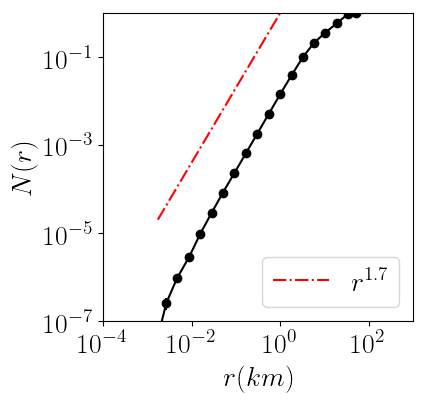

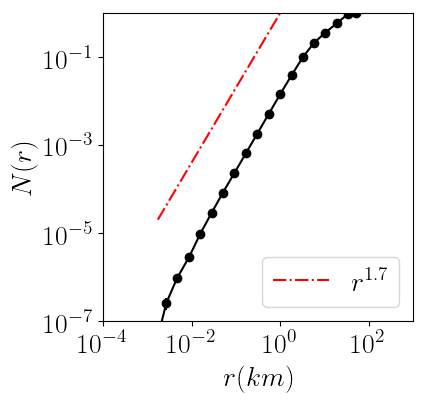

In [49]:
#--- plot
d_f = 1.7
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.axis([1e-4,1e3,1e-7,1e0])
ax.set_xlabel('$r(km)$')
ax.set_ylabel('$N(r)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar( r_bins2d, hist_acc_2d, 
            yerr = hist_acc_2d/hist2d**.5,
            color='black',marker='o')
# ax.errorbar( r_bins3d, hist_acc_3d, 
#             yerr = hist_acc_3d/hist3d**.5,
#             color='red',marker='s')

#ax.errorbar( r_bins, 10000*hist_acc/r_bins**d_f,  #--- rescaled
#            yerr = hist_acc/hist**.5/r_bins**d_f,
#            color='red',marker='o',label='$N/r^{%s}$'%d_f)
ax.plot(r_bins2d, r_bins2d**d_f,
        '-.r',label='$r^{%s}$'%d_f)

ax.legend()

fig.savefig('%s/corrDim.png'%DIR_OUTPT_figs,bbox_inches='tight')
plt.show()

In [ ]:
#--- evaluate fractal dimension (box counting )

import geopy.distance
from math import *
import random as rnd
#import warnings

#warnings.filterwarnings('ignore') #--- get rid of warnings

#def GetCartesian( dff ):
#    df = dff.copy()
#    xlo = df['longitude'].min()
#    xhi = df['longitude'].max()
#    ylo = df['latitude'].min()
#    yhi = df['latitude'].max()
#    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
#    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
#    df[ 'r(km)' ] = df[ 'longitude' ].apply( getDistX ) + df[ 'latitude' ].apply( getDistY ) * 1j
#    df[ 'x(km)' ] = df[ 'longitude' ].apply( getDistX )
#    df[ 'y(km)' ] = df[ 'latitude' ].apply( getDistY )
#    return df

#--------------------
#----- subset
#--------------------
# swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
#                              'magnitude', 
#                              ( mc, sys.maxint ) ) 
# #swarm_lohi = swarm_lohi.sample( n = 1000 ) #--- sample


# #--------------------
# #--- cartesian coords
# #--------------------
# swarm_lohi = GetCartesian( swarm_lohi )
# #swarm_lohi = DataFrameSubSet( swarm_lohi, #--- complete catalog
# #                             'x(km)', 
# #                             ( 200, 1000 ) ) 
# #swarm_lohi = DataFrameSubSet( swarm_lohi, #--- complete catalog
# #                             'y(km)', 
# #                             ( -1000, 220 ) ) 

# #--------------------
# #--- scattered plot
# #--------------------
# plt.figure(figsize=(4,4))
# #plt.xlim(0,np.max(r_list))
# #plt.ylim(-np.max(r_list)/2,np.max(r_list)/2)
# plt.xlabel('x(km)')
# plt.ylabel('z(km)')
# plt.scatter(swarm_lohi['x(km)'],
#             swarm_lohi['z(km)'],
#                         s=3**(swarm_lohi['magnitude']),
#                         cmap='jet',
#                         alpha = 0.01) 
# #--------------------
# #--- box counting
# #--------------------
# #tmp=pd.DataFrame({'x(m)':swarm_lohi['y(m)'],'y(m)':swarm_lohi['z(m)']}) #,'z(m)':swarm_lohi['z(m)']})
# #rmat = getRmat2d( tmp )
# #rmat = getRmat2d( swarm_lohi )

# #r_list = rmat[rmat.nonzero()]
# #r_min = np.min(r_list)
# #r_max = np.max(r_list)
# #
# plt.savefig('%s/map2d.png'%DIR_OUTPT_figs,bbox_inches='tight')



In [ ]:
# #--- evaluate fractal dimension (box counting )


# def fractalDimension3d( x, y, z, L, dmin = None ):
#     x = np.array(x)
#     y=np.array(y)
#     z=np.array(z)
# #    xlo = x.min()
# #    xhi = x.max()
# #    ylo = y.min()
# #    yhi = y.max()
# #    zlo = z.min()
# #    zhi = z.max()
# #    L = max( zhi - zlo, yhi - ylo, xhi - xlo )
#     #---
#     xc = x.mean() #--- center
#     yc = y.mean()
#     zc = z.mean()
    
#     xo = xc - L #--- origin
#     yo = yc - L
#     zo = zc - L
# #    L *= 2.0
#     #---
#     kounter = 0  #--- number of divisions
#     dx = dy = dz = L  #--- scale
#     dl = []
#     N = []
#     while dx - dmin > 0.0: #--- do until dx < dmin
#         d = {}
#         index_i = np.array( map(int,np.floor( ( y - yo ) / dy ) ) )
#         index_j = np.array( map( int, np.floor( ( x - xo ) / dx ) ) )
#         index_k = np.array( map( int, np.floor( ( z - zo ) / dz ) ) )
        
#         inside_cell_lo = np.all([index_i>=0,index_j>=0,index_k>=0.0],axis=0) #--- point is inside?
#         inside_cell_hi = np.all([index_i<2**kounter,index_j<2**kounter,index_k<2**kounter],axis=0) #
#         inside_cell = np.all([inside_cell_lo,inside_cell_hi],axis = 0)

        
#         cell_id = index_k * 4 ** kounter + index_i * ( 2**kounter ) + index_j
#         #---
#         dl+=[dx]
#         N+=[len( set( cell_id ) )]
#         #---
#         kounter += 1
#         dx = dy = dz = L / 2**kounter
#     assert dx - dmin <= 0.0
#     #---
#     return np.array(dl), np.array(N)


# def fractalDimension2d( x, y, L, dmin = None ):
#     x = np.array(x)
#     y=np.array(y)
# #    xlo = x.min()
# #    xhi = x.max()
# #    ylo = y.min()
# #    yhi = y.max()
# #    L = max( yhi - ylo, xhi - xlo )
#     #---
#     xc = x.mean() #--- center
#     yc = y.mean()

#     xo = xc - L #--- origin
#     yo = yc - L
# #    L *= 2.0
#     #---
#     kounter = 0  #--- number of divisions
#     dx = dy = L / 2**kounter  #--- scale
#     dl = []
#     N = []
# #    pdb.set_trace()
# #    fig = plt.figure(figsize=(4,4))
# #    ax=fig.add_subplot(111)
# #    plt.scatter(x,y)
# #    ax.add_patch( patches.Rectangle(xy=(xo,yo), width=L, 
# #                                    height=L, linewidth=1,
# #                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
#     while dx - dmin > 0.0: #--- do until dx < dmin
#         d = {}
        
#         index_i = np.array( map(int,np.floor( ( y - yo ) / dy ) ) ) #--- assingn index
#         index_j = np.array( map( int, np.floor( ( x - xo ) / dx ) ) )

#         inside_cell_lo = np.all([index_i>=0,index_j>=0],axis=0) #--- point is inside?
#         inside_cell_hi = np.all([index_i<2**kounter,index_j<2**kounter],axis=0) #
#         inside_cell = np.all([inside_cell_lo,inside_cell_hi],axis = 0)
        
#         index_i = index_i[ inside_cell ] #--- subset of the index array
#         index_j = index_j[ inside_cell ]

#         cell_id = index_i * ( 2**kounter ) + index_j
#         #---
#         dl+=[dx]
#         N+=[len( set( cell_id ) )]
#         #---
#         kounter += 1
#         dx = dy = L / 2**kounter
#     assert dx - dmin <= 0.0
#     #---
#     return np.array(dl), np.array(N)


# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax.set_xlabel('$r(km)$')
# ax.set_ylabel('$N(r)$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax2.set_xlabel('$r(km)$')
# ax2.set_ylabel(r'$N(r)\times r^{%s}$'%d_f)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# dl={}
# N={}
# count = 0
# r_min = np.min(r_list)
# r_max = np.max(r_list)
# for L in np.logspace(log(r_min,2),log(r_max,2),num=6,base=2.0):
# #for L in [2*420.0]:
# #    dl[count], N[count] = fractalDimension2d( swarm_lohi['x(km)'],
# #                                              swarm_lohi['y(km)'], L, dmin=r_min ) # , swarm_lohi['z(m)'], dmin=r_min )
#     dl[count], N[count] = fractalDimension3d( swarm_lohi['x(km)'],
#                                              swarm_lohi['y(km)'], 
#                                              swarm_lohi['z(km)'], 
#                                              L, dmin=r_min ) 

# ##--- try random
# #x=np.array([rnd.random() for i in xrange(1000)])
# #y=0.2*x #[rnd.random() for i in xrange(10000)]
# ##z=x #[rnd.random() for i in xrange(10000)]
# #tmp=pd.DataFrame({'x(m)':x,'y(m)':y})#,'z(m)':z})
# #rmat = getRmat2d( tmp )
# #r_list = rmat[rmat.nonzero()]
# #r_min = min(r_list)
# #sdict = fractalDimension2d( x,y,
# #                           dmin=r_min )
# #plt.scatter(x,y)

# #--- plot
#     #ax.set_xlim(10**r_min,10**r_max)
#     #for key in sdict:
#     ax.plot(dl[count],N[count],'-o')
#     ax2.plot(dl[count],N[count]*dl[count]**d_f,marker='o',label='$L=%2.1e$'%L)#,linestyle='None')
#     count+=1
# ax2.legend(bbox_to_anchor=(1, 1))
# fig.tight_layout()

# fig.savefig('%s/boxCount.png'%DIR_OUTPT_figs,bbox_inches='tight')
    

In [10]:
Df = 1.7
bval = 0.8
mc=1.5


In [13]:
#--- trig analysis (new) (it's a large data sets. run the simulation on a cluster and use the outputs)

from scipy.sparse import lil_matrix
import time
from IPython.display import display
import datetime
import pdb
import numpy.linalg
import numpy as np

def UpperTriang(a):
    il1 = np.tril_indices(a.shape[0])
    a[il1] = 0
    return a
    
def getTmat( df_complete ):
    nmax = len( df_complete )
    prefact = 1.0 / ( 24.0 * 60 * 60 ) #--- daily
    tmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    tmat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        df_dt = ( df_complete[ 'date' ] - df_complete[ 'date' ][ i ] ).dt.total_seconds() * prefact #--- time diff between i-th event and all subsequent events	
        tmat[ i ] = np.array(df_dt)
        df_dt[ : i ] = df_dt[ i ] #--- must have an upper triangular matrix 
        tmat_ut[ i ] = np.array(df_dt)

        #---
    return np.array( tmat ), np.array( tmat_ut )


def AddPositionList(df_complete):
    df_complete['r(m)'] = df_complete['x(m)'].apply(lambda x: [x])+ \
                          df_complete['y(m)'].apply(lambda x: [x])+ \
                          df_complete['z(m)'].apply(lambda x: [x])

def getRmat( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    rmat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = ( df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ] )
        df_dy = ( df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ] )
#---        df_dz = ( df_complete[ 'z(km)' ] - df_complete[ 'z(km)' ][ i ] ) comment if 2-d
        df_sq = ( df_dx * df_dx + df_dy * df_dy ) ** 0.5 # + df_dz * df_dz ) ** 0.5
        rmat[ i ] = np.array(df_sq)
        df_sq[ : i ] = 0
        rmat_ut[ i ] = np.array(df_sq)
    return np.array( rmat ), np.array( rmat_ut )

def getMmat( df_complete ):
    nmax = len( df_complete )
    m_mat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    m_mat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- magnitude
        df_m = pd.Series( [ df_complete[ 'magnitude' ][ i ] ] * nmax )
        m_mat[ i ] = np.array(df_m)
        df_m[ : i ] = 0
        m_mat_ut[ i ] = np.array(df_m)
    return np.array( m_mat ), np.array( m_mat_ut ) 

def vectorizedAnalysis( df_complete ):
    #--- setup t, r, m
    t0 = time.time()
    tmat0, tmat = getTmat( df_complete )
    print 'setting up tmat:%s s'%(time.time() - t0)
    t0 = time.time()
    r_mat0, r_mat = getRmat( df_complete )
    print 'setting up rmat:%s s'%(time.time() - t0)
    t0 = time.time()
    m_mat0, m_mat = getMmat( df_complete )
    print 'setting up m_mat:%s s'%(time.time() - t0)
      
        
#    #--- make upper-triangular matrices    
#    t0 = time.time()
#    tmat = UpperTriang(np.copy(tmat0))
#    r_mat = UpperTriang(np.copy(r_mat0))
#    m_mat = UpperTriang(np.copy(m_mat0))
#    print 'setting up ut matrix:%s s'%(time.time() - t0)
    
    #--- nij
    t0 = time.time()
    NIJ = tmat * r_mat ** ( Df ) * 10 ** ( - bval * ( m_mat - mc ) )
    TIJ = tmat * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    RIJ = r_mat ** ( Df ) * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    print 'setting up NIJ:%s s'%(time.time() - t0)
    nmax = len( df_complete )
    N_sparse = lil_matrix( ( nmax, nmax ) ) #--- sparse matrix
    T_sparse = lil_matrix( ( nmax, nmax ) )
    R_sparse = lil_matrix( ( nmax, nmax ) )
    for junk, j in zip( NIJ, xrange( sys.maxint ) ): 
        if j == 0:
            continue
        x = min( NIJ[ : j, j ][ NIJ[ : j, j ] != 0 ] ) #--- min nij
        assert x != 0.0
        rowi = np.where( NIJ[ : j, j ] == x )[ 0 ][ 0 ] #--- find row
        assert rowi <= j
        N_sparse[ rowi, j ] = x #--- insert
        T_sparse[ rowi, j ] = TIJ[ rowi, j ]
        R_sparse[ rowi, j ] = RIJ[ rowi, j ]    
    return N_sparse, (T_sparse, tmat0 ), ( R_sparse, r_mat0 ), m_mat0


#--------------------
#----- subset
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

#--------------------
#--- cartesian coords
#--------------------
swarm_lohi = GetCartesian( swarm_lohi )

#AddPositionList( swarm_lohi )
swarm_lohi.reset_index(inplace=True,drop=True)

#--- vectorized
t0 = time.time()
N_sparse, (T_sparse,tmat), (R_sparse,rmat), m_mat = vectorizedAnalysis( swarm_lohi )
print 'duration=%s s'%(time.time() - t0)

setting up tmat:73.3103041649 s
setting up rmat:66.4546861649 s
setting up m_mat:45.3270878792 s
setting up NIJ:163.628949165 s
duration=413.345365047 s


In [14]:
#--- random analysis

def shuffle(amat):
    ind_list = range(amat.shape[0])
    np.random.shuffle(ind_list)
    amat_row = amat[ind_list]
    return amat_row[:,ind_list]

def GetNij(rmat,tmat,m_mat,df_complete):
    
    tmat = shuffle(np.abs(tmat))
    r_mat = shuffle(rmat)
    m_mat = shuffle(m_mat)
    
    #--- nij
    NIJ = tmat * r_mat ** ( Df ) * 10 ** ( - bval * ( m_mat - mc ) )
    TIJ = tmat * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    RIJ = r_mat ** ( Df ) * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    nmax = len( df_complete )
    N_sparse = lil_matrix( ( nmax, nmax ) ) #--- sparse matrix
    T_sparse = lil_matrix( ( nmax, nmax ) )
    R_sparse = lil_matrix( ( nmax, nmax ) )
    for junk, j in zip( NIJ, xrange( sys.maxint ) ): 
        if j == 0:
            continue
            
        x = min( NIJ[ : j, j ][ NIJ[ : j, j ] != 0 ] ) #--- min nij
        assert x != 0.0
        rowi = np.where( NIJ[ : j, j ] == x )[ 0 ][ 0 ] #--- find row
        N_sparse[ rowi, j ] = x #--- insert
        T_sparse[ rowi, j ] = TIJ[ rowi, j ]
        R_sparse[ rowi, j ] = RIJ[ rowi, j ]    
    return N_sparse, (T_sparse, tmat ), ( R_sparse, r_mat), m_mat

N_sparse_rnd = {}
T_sparse_rnd = {}
R_sparse_rnd = {}
tmat_rnd = {}
rmat_rnd = {}
nsamp = 1
tmat = np.abs(tmat)
for i in xrange(nsamp):
    print i
    N_sparse_rnd[i], (T_sparse_rnd[i],tmat_rnd[i]), (R_sparse_rnd[i],rmat_rnd[i]), junk = GetNij(rmat,tmat,m_mat,swarm_lohi)


0


In [16]:
#--- save sparse matrices

import scipy.sparse

for mat, title in zip([N_sparse,T_sparse,R_sparse],
                     ['N_sparse_matrix.npz','T_sparse_matrix.npz','R_sparse_matrix']):
   scipy.sparse.save_npz('%s/%s'%(DIR_OUTPT,title), mat.tocsr()) #--- output

for mat, title in zip([N_sparse_rnd[0],T_sparse_rnd[0],R_sparse_rnd[0]],
                     ['N_sparse_rnd_matrix.npz','T_sparse_rnd_matrix.npz','R_sparse_rnd_matrix']):
   scipy.sparse.save_npz('%s/%s'%(DIR_OUTPT,title), mat.tocsr()) #--- output

#swarm_shuffled.to_csv('%s/swarm_shuffled.csv'%DIR_OUTPT)

In [14]:
#--- load sparse matrices
#--- 1- run on the cluster: 
#--- 2- sbatch --mem=8gb --partition=single  --time=02:59:59 -n 1 ./oarScript.sh
#--- 3- oarScript.sh: source activate conda-env; python ./swarmEMC.py
#--- 4- copy: scp arc:/home/kamran.karimi1/Project/seismic/dataset/El_Mayor_Cucpah/* ./swarm/dataset/El_Mayor_Cucpah/

import scipy.sparse

N_sparse = scipy.sparse.load_npz('%s/N_sparse_matrix.npz'%DIR_OUTPT )
T_sparse = scipy.sparse.load_npz('%s/T_sparse_matrix.npz'%DIR_OUTPT )
R_sparse = scipy.sparse.load_npz('%s/R_sparse_matrix.npz'%DIR_OUTPT )
#rmat = np.load('%s/rmat.npy'%DIR_OUTPT)
#tmat = np.load('%s/tmat.npy'%DIR_OUTPT)

N_sparse_rnd = {}
T_sparse_rnd = {}
R_sparse_rnd = {}

nsamp = 1
N_sparse_rnd[0] = scipy.sparse.load_npz('%s/N_sparse_rnd_matrix.npz'%DIR_OUTPT )
T_sparse_rnd[0] = scipy.sparse.load_npz('%s/T_sparse_rnd_matrix.npz'%DIR_OUTPT )
R_sparse_rnd[0] = scipy.sparse.load_npz('%s/R_sparse_rnd_matrix.npz'%DIR_OUTPT )
#rmat_rnd = np.load('%s/rmat_rnd.npy'%DIR_OUTPT)
#tmat_rnd = np.load('%s/tmat_rnd.npy'%DIR_OUTPT)

#swarm_shuffled = pd.read_csv('%s/swarm_shuffled.csv'%DIR_OUTPT)
#swarm_shuffled_incomplete = pd.read_csv('%s/swarm_shuffled_incomplete.csv'%DIR_OUTPT)

In [15]:
##--- matrix map of nij & nij_rand
#
#plt.subplot(2,1,1)
#plt.pcolormesh(np.log(N_sparse.toarray()),cmap='jet')
#plt.subplot(2,1,2)
#plt.pcolormesh(np.log(N_sparse_rnd.toarray()),cmap='jet')


n_th=4.4e-05+0.0e+00


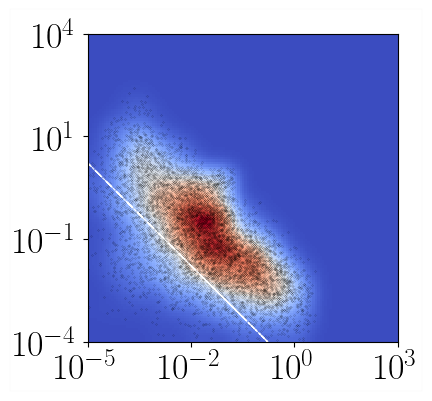

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 26}
matplotlib.rc('font', **font)

#---------------------------
#--- compute threshold n_th
#---------------------------

def PLOT(edges, hist, cdf, title ):
    #--- plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
#    plt.xlim(1e-13,1)
#    plt.ylim(1e-1,1e13)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('nij')
    plt.ylabel('P(nij)')
    plt.title( title )
    plt.plot(edges[:-1],hist,'.-')
    
    plt.subplot(1,2,2)
#    plt.xlim(1e-13,1)
#    plt.ylim(1e-3,1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('nij')
    plt.ylabel('cdf')
    plt.plot(edges[:-1],cdf,'.-')
    plt.plot([n_thresh for i in edges[:-1]], cdf)
#---    
def HIST( nij, nbins ):
    #--- histograms
    nij_TxR = nij['T*']*nij['R*']
    hist, edges = np.histogram( nij_TxR,
                            bins=np.logspace(np.log(nij_TxR.min()),np.log(nij_TxR.max()),nbins),
                            density=True)
    #--- accumulated
    cdf, edges = np.histogram( nij_TxR,
                           bins=np.logspace(np.log(nij_TxR.min()),np.log(nij_TxR.max()),nbins,endpoint=True))
    cdf=np.cumsum(cdf)
    #assert cdf[-1] == len(nij_TxR), '%s,%s'%(cdf[-1], len(nij_TxR))
    N = 1.0 * len(nij_TxR)
    cdf = cdf / N
    return edges, hist, cdf

def reset_xticks(nn,ax,(TMIN,TMAX)):
    ax.set_xticks( np.linspace(ax.axis()[0],ax.axis()[1],nn) ) 
    labels=np.linspace(TMIN,TMAX,nn)
    labels = [r'$10^{%i}$'%i for i in labels]
    ax.set_xticklabels(labels)

def reset_yticks(nn,ax,(RMIN,RMAX)):
    ax.set_yticks( np.linspace(ax.axis()[2],ax.axis()[3],nn) ) 
    labels=np.linspace(RMIN,RMAX,nn)
    labels = [r'$10^{%i}$'%i for i in labels]
    ax.set_yticklabels(labels)
                 

def GetTrigListLoHi( nij_trig, col, (tlo,thi), swarm_lohi ):
    list_of_mothers = nij_trig.groupby(by='Parent_id').groups.keys() 
    list_of_mothers.sort()
    tmp_df = swarm_lohi.loc[ list_of_mothers ]
    tmp_df = tmp_df[ (tmp_df[ col ] >= tlo) & 
                 (tmp_df[ col ] < thi) ]
    return nij_trig[ pd.DataFrame([nij_trig['Parent_id'] == i for i in tmp_df.index]).any() ]

def GetInterpolatedData( df0, (TMIN,TMAX),(RMIN,RMAX) ):
    nbins_per_decade = 16
    nbins_x=nbins_y=int(TMAX-TMIN)*nbins_per_decade
    df=df0.copy()

    df['T*']=df[ 'T*' ].apply(lambda x: log(x,10))
    df['R*']=df[ 'R*' ].apply(lambda x: log(x,10))
    heatmap, xedges, yedges = np.histogram2d( df[ 'T*' ], df[ 'R*'], bins=[np.linspace(TMIN,TMAX,nbins_x+1), np.linspace(RMIN,RMAX,nbins_y+1)], normed=True)
    heatmap *= len( df )
    heatmap = gaussian_filter( heatmap, sigma = nbins_per_decade/4 )
    return heatmap

def GetDistance( df1, df2 ):
    df_sq = (np.array( df1['x(km)'] ) - np.array( df2['x(km)'] ) ) ** 2 + \
            (np.array( df1['y(km)'] ) - np.array( df2['y(km)'] ) ) ** 2 + \
            (np.array( df1['z(km)'] ) - np.array( df2['z(km)'] ) ) ** 2 
    return pd.Series( df_sq ** 0.5 )

def RemovePair( dff, cs, catalog ):
    pref = 1.0 / 3600.0 / 24 #--- daily
    df = dff.copy()
    
    series_r = GetDistance(catalog.loc[df['Parent_id']],catalog.loc[df['Event_id']])
     
#    series_r = pd.Series(np.array( catalog.loc[df['Parent_id']]['r(km)'] ) -\
#                         np.array( catalog.loc[df['Event_id']]['r(km)'] ) )
    assert len(series_r[series_r==np.nan]) == 0
    df['R'] = series_r.copy() #abs()

    series_t = pd.Series(np.array( catalog.loc[df['Event_id']]['date'] ) -\
                         np.array( catalog.loc[df['Parent_id']]['date'] ) )
    df['T'] = series_t.apply(lambda x:x.total_seconds()*pref)
    assert len ( df[ df['R'] == 0.0 ] ) == 0, '%s'%display( df[ df['R'] == 0.0 ] )
    assert len ( df[ df['T'] == 0.0 ] ) == 0, '%s'%display( df[ df['T'] == 0.0 ] )
    return df [ df[ 'R' ] <= df[ 'T' ] * cs ]


#--------------------
#----- set parameters
#--------------------
#--- set quantile
quantile = 0.05 #new_quantile #0.050
#--- wave speed
cs = 3 * (24*3600) #--- km per day
#--- cut-off time
dt_cut = 1.0 #--- day
#--- plot scattered
TMIN=-5
TMAX=3
RMIN=-4
RMAX=4


#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi = GetCartesian( swarm_lohi )
swarm_lohi.reset_index(inplace=True,drop=True)


#--------------------
#--- store actual data in a dataframe
#--------------------
rows, cols = N_sparse.nonzero()
tlist = T_sparse[rows, cols].tolist()[0]
rlist = R_sparse[rows, cols].tolist()[0]
nij = pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist})

#--------------------
#--- store random data in a dataframe
#--------------------
nij_rnd = {}
for i in xrange(nsamp):
    rows, cols = N_sparse_rnd[i].nonzero()
    tlist = T_sparse_rnd[i][rows, cols].tolist()[0]
    rlist = R_sparse_rnd[i][rows, cols].tolist()[0]
    nnn = len(cols)
    nij_rnd[i] = pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist},index=range(i*nnn,(i+1)*nnn))


#--------------------------------------------
#----- only include mother events with 
#----- t_mother between (t_lo, t_hi) 
#--------------------------------------------
#--- actual data
#--- remove pairs with r > cs.t
nij = RemovePair( nij, cs, swarm_lohi )
myTlohi = Tlohi(swarm_lohi['date'].min()+datetime.timedelta(days=dt_cut), #--- set cut-off time
               swarm_lohi['date'].max()+datetime.timedelta(days=-dt_cut)
               )
nij = GetTrigListLoHi( nij, 'date',  #--- t_mother > t_lo
                       ( myTlohi.lo, myTlohi.hi ), 
                           swarm_lohi)
nij.reset_index(inplace=True, drop=True)

#--- random data
#for i in xrange(nsamp):
#    nij_rnd = RemovePair( nij_rnd, cs, swarm_shuffled )
#    nij_rnd = GetTrigListLoHi( nij_rnd, 'date', 
#                       ( myTlohi.lo, myTlohi.hi ), 
#                           swarm_shuffled)
#    nij_rnd.reset_index(inplace=True, drop=True)

#--- compute threshold
N_thresh = []
frames = []
for i in xrange(nsamp):
    frames.append(nij_rnd[i])
    #--- plot histograms for random data
    edges, hist, cdf = HIST( nij_rnd[i], 1024 )
#    edges = 0.5*(edges[:-1]+edges[1:])
    N_thresh.append(edges[:-1][cdf>quantile][0])
n_thresh = np.mean(N_thresh)
print 'n_th=%2.1e+%2.1e' %(n_thresh,np.std(N_thresh) / nsamp ** 0.5)
Nij_rnd = pd.concat([nij_rnd[i]]) #frames)


#--- distribution of nij (actual data)
edges_actual, hist_actual, cdf_actual = HIST( nij, 1024 )
#edges_actual = 0.5*(edges_actual[:-1]+edges_actual[1:])
#PLOT(edges, hist, cdf, 'random')


#--------------------
#--- plot scattered
#--------------------
fig = plt.figure(figsize=(4,4))


#--------------------
#--- interpolated data
#--------------------
#for nn, index, title in zip([ nij, Nij_rnd ],xrange(2),['actual','randomized']):
for nn, index, title in zip([ nij ],xrange(2),['actual']):
    ax = fig.add_subplot(111) #,2,index+1)
    #--- interpolate
    heatmap=GetInterpolatedData(nn,(TMIN,TMAX),(RMIN,RMAX))
    ax.pcolormesh(heatmap.T,cmap='coolwarm')
    #---
#    ax.set_xlabel('T*')
#    ax.set_ylabel('R*')
#    ax.set_title(title)
    ##--- reset x-ticks
    
    reset_xticks(4,ax,(TMIN,TMAX))
    #--- reset y-ticks
    reset_yticks(4,ax,(RMIN,RMAX))
    #--- nij must be within limits
    nij_copy = nn.copy()
    nij_copy=nij_copy[(nij_copy['T*'] >= 10**TMIN ) &
    (nij_copy['T*'] < 10**TMAX ) &
    (nij_copy['R*'] >= 10**RMIN ) &
    (nij_copy['R*'] < 10**RMAX )]
    #--- mapping
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(nij_copy['R*'])-RMIN)/(RMAX-RMIN)
    ax.set_xlim(ax.axis()[0],ax.axis()[1])
    ax.set_ylim(ax.axis()[2],ax.axis()[3])
    #--- plot                 
    DrawFrame(ax, (0.25,0.08),(0.16,0.08),0.01)
    ax.scatter(xx,
              yy,
               alpha=1,color='black',s=0.01)
    #--- draw the separation line
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(n_thresh/nij_copy['T*'])-RMIN)/(RMAX-RMIN)
#    print len(xx)
#    xx=xx[0:-1:300]
#    yy=yy[0:-1:300]
#    print len(xx)
    ax.plot( xx, yy,'-.',color='white',linewidth=1.0)
    
fig.savefig('%s/densityMaps.png'%DIR_OUTPT_figs,bbox_inches='tight',dpi=150)
#---
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings
rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

In [57]:
print myTlohi.lo
print myTlohi.hi

2019-09-02 17:02:55.320000
2019-05-17 23:43:03.600000


In [19]:
#--- triggering part
nij_trig=nij[nij['T*']*nij['R*']<=n_thresh]
display(nij_trig.info())
trig_ratio = cdf_actual[edges_actual[:-1]<=n_thresh][-1]
print 'trig_ratio=%s'%trig_ratio

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1187 entries, 2 to 7865
Data columns (total 6 columns):
Event_id     1187 non-null int32
Parent_id    1187 non-null int32
R*           1187 non-null float64
T*           1187 non-null float64
R            1187 non-null float64
T            1187 non-null float64
dtypes: float64(4), int32(2)
memory usage: 55.6 KB


None

trig_ratio=0.15159979685119349


In [90]:
n_thresh

4.4439634040912633e-05

In [ ]:
#trig_ratio *= 0.75
#n_thresh_new = edges_actual[:-1][cdf_actual <= trig_ratio][-1]
#new_quantile = cdf[edges[:-1]<=n_thresh_new][-1]
#print 'new_quantile=%s'%new_quantile
#n_thresh = n_thresh_new

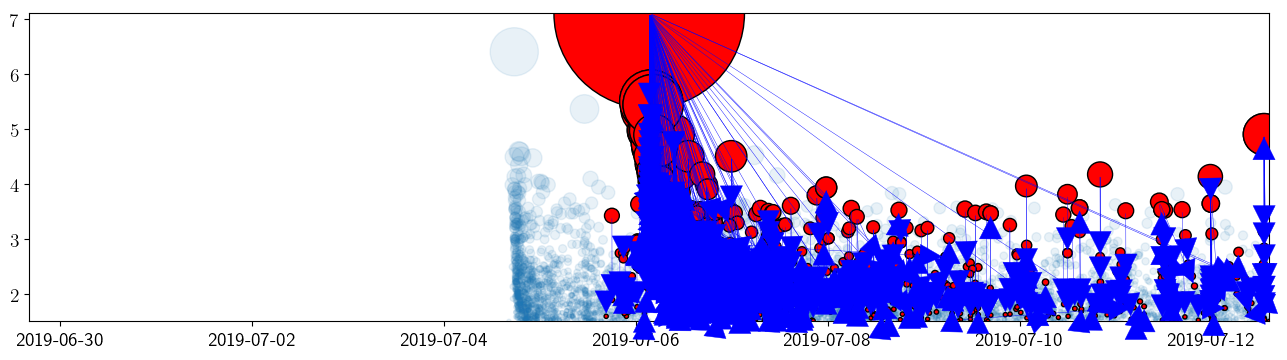

In [20]:
#--- plot clusters


def Inside(t,(tmin,tmax)):
    if tmin<= t<tmax:
        return True
    return False    

def GetTrigList( nij_trig ):
    d_trig = {}
    for items in nij_trig.itertuples():
        triggerID = items.Parent_id
        d_trig.setdefault( triggerID, [] ).append( items.Event_id )
    return d_trig

def PlotArrowsTime(df_complete,d_trig, (tmin,tmax), (xmin,xmax), (ymin,ymax) ):
    tlist=[]
    mlist=[]
    for triggerID in d_trig: #--- mother events
        
        t0 = df_complete['date'].iloc[ triggerID ] #--- time of mother event
        m0 = df_complete['magnitude'].iloc[triggerID] #--- magnitude
        
        if not ( Inside(t0,(tmin,tmax) ) and #--- within the given interval
                 Inside(swarm_lohi['x(km)'].iloc[triggerID],(xmin,xmax)) and 
                 Inside(swarm_lohi['y(km)'].iloc[triggerID],(ymin,ymax)) ):
            continue

#        x0 = md.date2num( t0 ) #--- convert to time object
#        y0 = m0 #--- magnitude
        
        tlist.append( t0 )
        mlist.append( m0 )

        for daughter_id in d_trig[triggerID]: #--- children
            
            t1 = df_complete['date'].iloc[ daughter_id ] #--- time
            m1 = df_complete['magnitude'].iloc[ daughter_id ] #--- magnitude
            
            tlist.append( t1 )
            mlist.append( m1 )
            
            if not ( Inside(t1,(tmin,tmax) ) and #--- within the given interval
                     Inside(swarm_lohi['x(km)'].iloc[daughter_id],(xmin,xmax)) and 
                     Inside(swarm_lohi['y(km)'].iloc[daughter_id],(ymin,ymax)) ):
                continue
                
#            x1 = md.date2num( t1 ) #--- convert to time object
#            y1 = m1 #--- magnitude

#            xw = x1 - x0 #--- t_child-t_parent
#            yw = y1 - y0 #--- m_child - m_parent
            plt.annotate("", (t1,m1), xytext=(t0, m0),
                         textcoords='data',
                        arrowprops=dict(arrowstyle="-|>,head_width=.4,head_length=.8",color="b",linewidth="0.3")) 
    
    #--- plot circles
    df=pd.DataFrame({'date':tlist,'mag':mlist})
    plt.scatter(df['date'], df['mag'],
                s=4**(df['mag']),
                alpha=1,
                facecolors='red',color='black')
    #plt.savefig('timeSeries.png')
    
#--------------------------------------
#----- key: event value: aftershock id
#--------------------------------------
d_trig = GetTrigList( nij_trig )

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

#--------------------
#--- cartesian coords
#--------------------
swarm_lohi = GetCartesian( swarm_lohi )



#--- plot arrows
#dt=30
for ii in xrange(1):
    #--- setup
    fig = plt.figure(figsize=(16,4),frameon=False) #, dpi=300)
    #--- xlimit
    xmin = swarm_lohi['longitude'].min()
    xmax = swarm_lohi['longitude'].max()
    ymin = swarm_lohi['latitude'].min()
    ymax = swarm_lohi['latitude'].max()
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    
    #--- plot all events
    plt.ylim(mc,swarm_lohi['magnitude'].max())
    plt.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
                s=2*np.exp(swarm_lohi['magnitude']),
            alpha=0.1)

    key_max = swarm_lohi.loc[nij_trig.groupby(by='Parent_id').groups.keys()]['magnitude'].sort_values(ascending=False).index[ii]
#    print 'key=',key_max
#    print 't=',swarm_lohi.loc[key_max]['date']
#    print 'x=',swarm_lohi.loc[key_max]['x(km)'],
#    print 'y=',swarm_lohi.loc[key_max]['y(km)'],
#    print 'z=',swarm_lohi.loc[key_max]['z(km)']
    dt = nij_trig[nij_trig['Parent_id']==key_max]['T'].max()
    dx = nij_trig[nij_trig['Parent_id']==key_max]['R'].max()
    tt=swarm_lohi['date'].loc[key_max]
    xx = swarm_lohi.loc[key_max][['x(km)','y(km)','z(km)']]
    PlotArrowsTime( swarm_lohi, d_trig,
                       ( tt+datetime.timedelta(days=-dt),tt+datetime.timedelta(days=+dt)), 
           (xx['x(km)']-dx,xx['x(km)']+dx),
           (xx['y(km)']-dx,xx['y(km)']+dx) )
    plt.xlim(tt+datetime.timedelta(days=-dt),tt+datetime.timedelta(days=+dt))

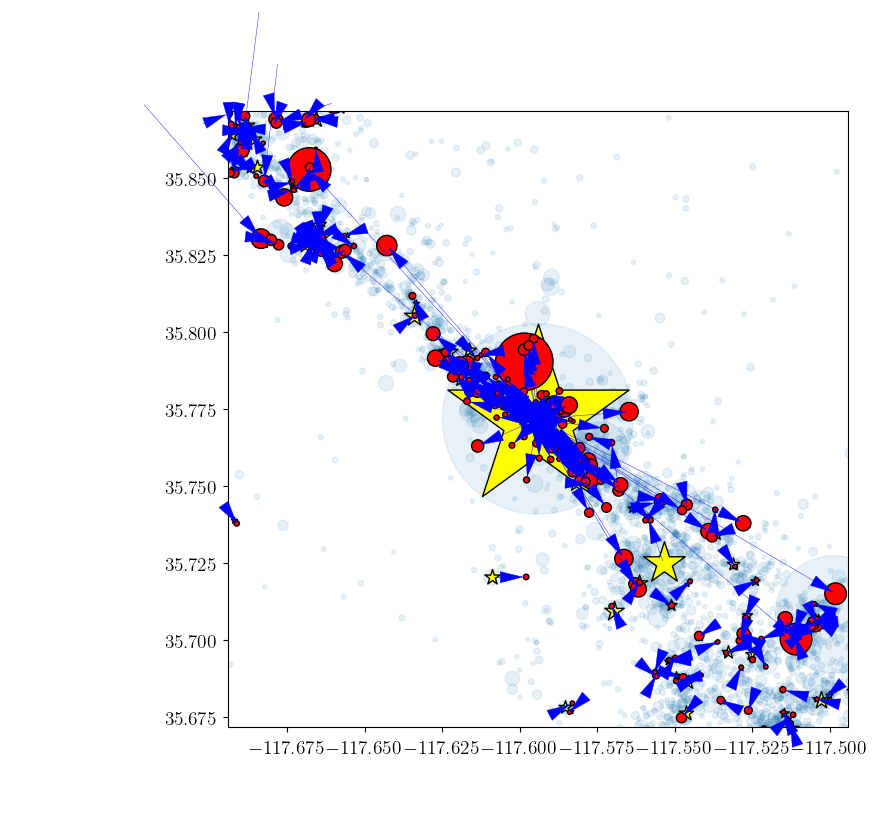

In [21]:
#--- plot clusters


def Inside(t,(tmin,tmax)):
    if tmin<= t<tmax:
        return True
    return False    

def GetTrigList( nij_trig ):
    d_trig = {}
    for items in nij_trig.itertuples():
        triggerID = items.Parent_id
        d_trig.setdefault( triggerID, [] ).append( items.Event_id )
    return d_trig

    
def PlotArrowsSpace(df_complete,d_trig, (tmin,tmax), (xmin,xmax), (ymin,ymax) ):
    xlist=[]
    ylist=[]
    mlist=[]
    for triggerID in d_trig: #--- mother events
        
        t0 = df_complete['date'].iloc[ triggerID ] #--- time of mother event
        ( x0, y0 ) = ( swarm_lohi['longitude'].iloc[triggerID], 
                       swarm_lohi['latitude'].iloc[triggerID] )
        m0 = df_complete['magnitude'].iloc[triggerID] #--- magnitude
        
#        if not ( Inside(t0,(tmin,tmax) ) and #--- within the given interval
 #                Inside(x0,(xmin,xmax)) and 
  #               Inside(y0,(ymin,ymax)) ):
   #         continue

        for daughter_id in d_trig[triggerID]: #--- children
            t1 = df_complete['date'].iloc[ daughter_id ] #--- time
            ( x1, y1 ) = ( swarm_lohi['longitude'].iloc[ daughter_id ], 
                           swarm_lohi['latitude'].iloc[ daughter_id ] )
            m1 = df_complete['magnitude'].iloc[ daughter_id ] #--- magnitude
            
            xlist.append( x1 )
            ylist.append( y1 )
            mlist.append( m1 )
            
#            if not ( Inside(t1,(tmin,tmax) ) and #--- within the given interval
#                     Inside(x1,(xmin,xmax)) and 
#                     Inside(y1,(ymin,ymax)) ):
#                continue

            ax.annotate("", (x1,y1), xytext=(x0, y0),
                         textcoords='data',
                        arrowprops=dict(arrowstyle="-|>,head_width=.2,head_length=.8",color="b",linewidth="0.3")) 
 
        #--- plot mother
        plt.scatter(x0,y0,
                    s=exponent**m0,
                    marker='*',
                    facecolors='yellow',color='black',
                    alpha=1.0)

    #--- plot circles
    df=pd.DataFrame({'x(km)':xlist,'y(km)':ylist,'m':mlist})
    ax.scatter(df['x(km)'], df['y(km)'],
                s=exponent**(df['m']),
                alpha=1,
                facecolors='red',color='black')
    
#--------------------------------------
#----- key: event value: aftershock id
#--------------------------------------
d_trig = GetTrigList( nij_trig )

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

#--------------------
#--- cartesian coords
#--------------------
swarm_lohi = GetCartesian( swarm_lohi )



#--- plot arrows
exponent = 4
for ii in xrange(1):
    #--- setup
    fig = plt.figure(figsize=(8,8)) #,frameon=False) #, dpi=300)
    ax = fig.add_subplot(111)
    #--- xlimit
    xmin = swarm_lohi['longitude'].min()
    xmax = swarm_lohi['longitude'].max()
    ymin = swarm_lohi['latitude'].min()
    ymax = swarm_lohi['latitude'].max()
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    #--- plot all events
    ax.scatter(swarm_lohi['longitude'], swarm_lohi['latitude'], # 'x(km)'],swarm_lohi['y(km)'],
                s=exponent**swarm_lohi['magnitude'],
                alpha=0.1)

#    key_max = swarm_lohi.loc[nij_trig.groupby(by='Parent_id').groups.keys()]['magnitude'].sort_values(ascending=False).index[ii]
    key_max = nij_trig.groupby(by='Parent_id').count()['R'].sort_values(ascending=False).index[ii]
    dt = nij_trig[nij_trig['Parent_id']==key_max]['T'].max()
    dx = 0.1 #nij_trig[nij_trig['Parent_id']==key_max]['R'].max()
    tt = swarm_lohi['date'].loc[key_max]
    xx = swarm_lohi.loc[ key_max ][['longitude','latitude']] #[['x(km)','y(km)','z(km)']]
    
    PlotArrowsSpace( swarm_lohi, d_trig,
                       ( tt+datetime.timedelta(days=-dt),tt+datetime.timedelta(days=+dt)), 
           (xx['longitude']-dx,xx['longitude']+dx),
           (xx['latitude']-dx,xx['latitude']+dx) )
    ax.set_xlim(xx[0]-dx,xx[0]+dx)
    ax.set_ylim(xx[1]-dx,xx[1]+dx)

In [ ]:
nij_trig.groupby(by='Parent_id').count()['R'].sort_values(ascending=False).index[0]

In [ ]:
#--- spatial clusters



#def GetCartesian2nd( dff ):
#    df = dff.copy()
#    xlo = df['longitude'].min()
#    xhi = df['longitude'].max()
#    ylo = df['latitude'].min()
#    yhi = df['latitude'].max()
#    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
#    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
#    df[ 'x' ] = df[ 'longitude' ].apply( getDistX )
#    df[ 'y' ] = df[ 'latitude' ].apply( getDistY )
#    return df


def PlotMap(df_complete,TRIG_ID, (tmin,tmax), (xmin,xmax), (ymin,ymax) ):
    #--- plot 
    counter = 0
    exponent=4
    for triggerID,colin in zip(TRIG_ID,colors):
        t0 = df_complete['date'].iloc[ triggerID ]
#        if not ( Inside(t0,(tmin,tmax) ) and 
#                 Inside(df_complete['y(m)'].iloc[triggerID],(xmin,xmax)) and 
#                 Inside(df_complete['z(m)'].iloc[triggerID],(ymin,ymax)) ):  
#              continue
        counter += 1
        if counter > 10:
            break
        #--- plot    
        fig = plt.figure(figsize=(5,5))#,dpi=150)
        ax = fig.add_subplot(111)
#        plt.xlim(xmin,xmax)
#        plt.ylim(ymin,ymax)
        plt.tick_params(axis='x', labelsize=14)
        plt.tick_params(axis='y', labelsize=14)
        plt.scatter(df_complete.loc[triggerID]['x(km)'],
                    df_complete.loc[triggerID]['y(km)'],
                    s=exponent**df_complete.loc[triggerID]['magnitude'],
                    facecolors='white',color='white')
        d={'x':[],'y':[],'m':[],'t':[]}
        #--- plot daughters
        for daughter_id in d_trig[triggerID]:
            t1 = df_complete['date'].iloc[ daughter_id ]
#            if not ( Inside(t1,(tmin,tmax) ) and 
#                     Inside(df_complete['y(m)'].iloc[daughter_id],(xmin,xmax)) and 
#                     Inside(df_complete['z(m)'].iloc[daughter_id],(ymin,ymax)) ):
#                continue
    #--- remove pairs with r > cs.t
#            if rmat[ triggerID, daughter_id ] > cs * tmat[ triggerID, daughter_id ]:
#                print 'hello!'
#                continue

            d['t'].append( t1 )
            d['x'].append(df_complete['x(km)'].iloc[daughter_id])
            d['y'].append(df_complete['y(km)'].iloc[daughter_id])
            d['m'].append(df_complete['magnitude'].iloc[daughter_id])
        df=pd.DataFrame(d)
        plt.scatter(df['x'],df['y'],
                    s=exponent**df['m'],
                    c=df['t'], cmap='jet') #,alpha=0.1)
        plt.colorbar()
        #--- plot mother
        plt.scatter(df_complete['x(km)'].iloc[triggerID],df_complete['y(km)'].iloc[triggerID],
                    s=exponent**df_complete['magnitude'].iloc[triggerID],
                    marker='*',
                    facecolors='yellow',color='black',
                    alpha=1.0)
        #--- 


    
colors = itertools.cycle(["r", "b", "g","b"])
#cs = 3 * (24*3600) #--- km per day

#--- sort
new_list = [[len(d_trig[triggerID]),triggerID] for triggerID in d_trig]
new_list.sort(reverse=True)
TRIG_ID = [i[1] for i in new_list]

#--- xlimit
swarm_lohi=GetCartesian(swarm_lohi)
#swarm_lohi['y(m)']=swarm_lohi['x']
#swarm_lohi['z(m)']=swarm_lohi['y']
xmin = swarm_lohi['x(km)'].min()
xmax = swarm_lohi['x(km)'].max()
ymin = swarm_lohi['y(km)'].min()
ymax = swarm_lohi['y(km)'].max()
#plt.tick_params(axis='x', labelsize=14)
#plt.tick_params(axis='y', labelsize=14)

#--- plot arrows
PlotMap( swarm_lohi, TRIG_ID,
#          (pd.to_datetime('2010-04-04'),pd.to_datetime('2010-06-26')),
#          (pd.to_datetime('2010-04-08'),pd.to_datetime('2010-04-14')),
                       ( swarm['date'].min(), swarm['date'].max()), 
           (xmin,xmax),
           (ymin,ymax) )

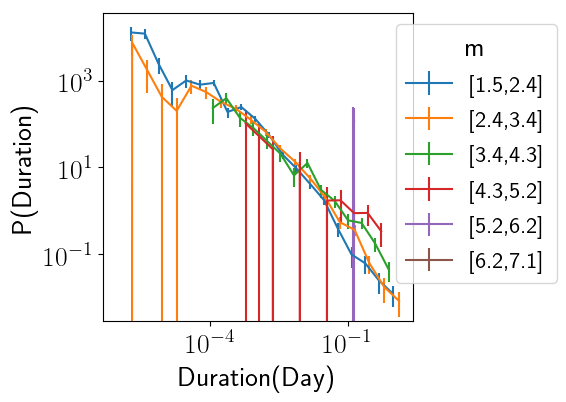

In [22]:
#--- cluster life time


def GetPairsWithSpecifiedParentMag((m0,m1),catalog,df):
    df_parents = df.groupby(by='Parent_id').groups #--- parent events
    ds = catalog['magnitude'].loc[df_parents.keys()] #--- mag. of parent events
    ds_m=ds[(m0 <= ds) & (ds < m1)] #--- parent events with m0<m<m1
    df_m=df[pd.DataFrame([df['Parent_id'] ==k for k in ds_m.index]).any()] #--- data frame
    return df_m

#def AddDist( df_trig, df_complete ):
#    x=df_complete.loc[ df_trig['Event_id'] ]['r(m)'] 
#    y=df_complete.loc[ df_trig['Parent_id'] ]['r(m)']
#    df_trig['R'] = pd.Series(numpy.linalg.norm(x-y)))
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )

def AddTime( df_trig, df_complete ):
    prefact = 1.0 / ( 24.0 * 60 * 60 ) #--- daily
    x=df_complete.loc[ df_trig['Event_id'] ]
    y=df_complete.loc[ df_trig['Parent_id'] ]
    x.reset_index(inplace=True)
    y.reset_index(inplace=True)
    df_trig['T'] = x['date']-y['date']
    df_trig['T'] = df_trig['T'].apply(lambda x: x.total_seconds() * prefact)

def RemovePair( df, cs ):
    return df [ df[ 'R' ] <= df[ 'T' ] * cs ]

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)


#--- choose m0<m<m1
n = 7
#m = list(np.linspace(mc,swarm['magnitude'].max(),n))
m_parents = swarm_lohi.loc[nij_trig.groupby(by='Parent_id').groups.keys()]['magnitude']
m = list(np.linspace(m_parents.min()-1e-6,m_parents.max()+1e-6,n))
#m+=[swarm['magnitude'].max()]

X={}
rho_dict={}
m_range={}
Err={}
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for i in xrange( len(m) - 1 ):
    m0 = m[ i ]
    m1 = m[ i + 1 ]
        
#    print m0, m1
#    nij_trig.groupby(by='Parent_id')
    
    df_trig = GetPairsWithSpecifiedParentMag((m0,m1),swarm_lohi,nij_trig) #--- get parent with m0<m<m1
    df_trig.reset_index( inplace = True, drop = True )
    #--- add distance & time column
#    df_trig['R'] = rmat[df_trig['Parent_id'],df_trig['Event_id']]
#    df_trig['T'] = tmat[df_trig['Parent_id'],df_trig['Event_id']]
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )
#    assert len ( df_trig[ df_trig['T'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['T'] == 0.0 ] )
    
    #--- remove pairs with r > cs.t
#    cs = 3 * (24*3600) #--- km per day
#    df_trig = RemovePair( df_trig, cs )

    #--- life time
    df_duration = df_trig.groupby(by='Parent_id')['T'].max()

    #--- rho plots
    n_decades = int( math.ceil( log(df_duration.max()/df_duration.min(),10) ) )
    nbin_per_decade = 3
    nbins =  nbin_per_decade * n_decades
    rho, xedges=np.histogram(df_duration, 
                             density=True,
                             bins=np.logspace(log(df_duration.min(),10),
                                              log(df_duration.max(),10),nbins))
    hist, xedges=np.histogram(df_duration,
                              bins=np.logspace(log(df_duration.min(),10),
                                               log(df_duration.max(),10),nbins))
    err = rho/np.sqrt(hist)
        
    
    #--- rho
#    plt.xlim(1e-3,1e2)
#    plt.ylim(1e-3,1e2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Duration(Day)')
    plt.ylabel('P(Duration)')
    plt.errorbar(xedges[:-1],rho, yerr=err,label='[%2.1f,%2.1f]'%(m0,m1))
    fontP = FontProperties()
    fontP.set_size('small')
    plt.legend(title='m',prop=fontP,loc='upper right',bbox_to_anchor=(1.5, 1))
    x=xedges[:-1]
    
    X[i] = x[:]
    rho_dict[i]=rho[:]
    m_range[i]=np.array([m0,m1])
    Err[i]=err[:]
plt.savefig('%s/duration.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')


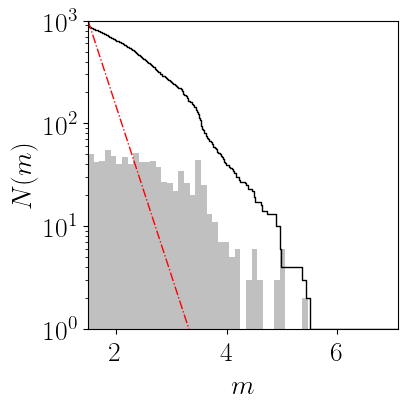

In [23]:
#--- histograms: magnitude of mother events

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)


mlist = swarm_lohi.loc[ nij_trig.groupby(by='Parent_id').groups.keys() ]['magnitude']
#plt.hist(mlist)

list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
mlist0= swarm_lohi['magnitude'].loc[df_zeros.index]


#--- accumulated histogram
N = len(mlist)+len(mlist0)
slist=mlist.tolist()+mlist0.tolist() #np.array(swarm_copy['magnitude'])
slist.sort()
d = histogramACCUMLTD( slist )
keys=d.keys()
keys.sort()

#--- plot
fig, ax = plt.subplots(figsize=(4,4))
ax.set_yscale('log')
ax.set_xlabel('$m$')
ax.set_ylabel('$N(m)$')
xmin=min(slist)
xmax=max(slist)
ax.axis([xmin,xmax,1,1000])
#ax.set_xticks(np.linspace(1,6,6))

dx=0.1
junk = ax.hist( slist,
                bins=int((xmax-xmin)/dx),
               label='histogram',color='silver') #--- histogram
xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(N-d[ikey][2])
ax.plot(xx,yy,
            linestyle='-', drawstyle='steps-post',color='black',
             linewidth=1.0) #--- accumulated
    
b=1.65
ax.plot([xmin,xmax],
        [1e3, 1e3* 10**(-b*(xmax-xmin))],'r-.',linewidth=1)

#DrawFrame(ax, (0.2,0.06),(0.14,0.06),0.1,LOG_Y=True)

plt.savefig('%s/gr.png'%DIR_OUTPT_figs,dpi=300,bbox_inches='tight',transparent=True)


alpha=0.4138698789480618


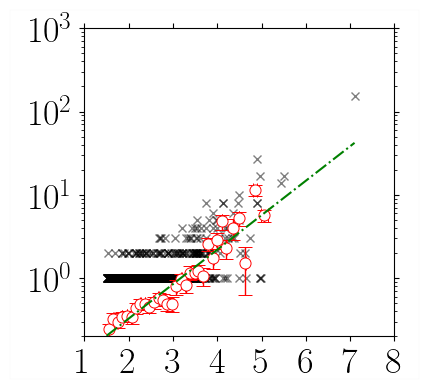

In [81]:
#--- productivity relation

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 26}
matplotlib.rc('font', **font)

import numpy as np
import math

def GetPairsWithSpecifiedParentMag((m0,m1),catalog,df):
    df_parents = df.groupby(by='Parent_id').groups #--- parent events
    ds = catalog['magnitude'].loc[df_parents.keys()] #--- mag. of parent events
    ds_m=ds[(m0 <= ds) & (ds < m1)] #--- parent events with m0<m<m1
    df_m=df[pd.DataFrame([df['Parent_id'] ==k for k in ds_m.index]).any()] #--- data frame
    return df_m, np.mean( ds_m ), np.std( ds_m )/(len(ds_m))**0.5 #--- exponential: std=mean

#def AddDist( df_trig, df_complete ):
#    x=df_complete.loc[ df_trig['Event_id'] ]['r(m)'] 
#    y=df_complete.loc[ df_trig['Parent_id'] ]['r(m)']
#    df_trig['R'] = pd.Series(numpy.linalg.norm(x-y)))
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )

def AddTime( df_trig, df_complete ):
    prefact = 1.0 / ( 24.0 * 60 * 60 ) #--- daily
    x=df_complete.loc[ df_trig['Event_id'] ]
    y=df_complete.loc[ df_trig['Parent_id'] ]
    x.reset_index(inplace=True)
    y.reset_index(inplace=True)
    df_trig['T'] = x['date']-y['date']
    df_trig['T'] = df_trig['T'].apply(lambda x: x.total_seconds() * prefact)

def RemovePair( dff, cs ):
    df = dff.copy()
    df['R'] = rmat[df['Parent_id'],df['Event_id']]
    df['T'] = tmat[df['Parent_id'],df['Event_id']]
    assert len ( df[ df['R'] == 0.0 ] ) == 0, '%s'%display( df[ df['R'] == 0.0 ] )
    assert len ( df[ df['T'] == 0.0 ] ) == 0, '%s'%display( df[ df['T'] == 0.0 ] )
    return df [ df[ 'R' ] <= df[ 'T' ] * cs ]

def AdjustBins(data,bins):
    hist, xedges=np.histogram(data, #--- histogram
                              bins=bins)
    tmp = [xedges[0]]
    for i,j in zip(xedges[1:],hist): #--- expand bins 
        if j < 2:
            continue
        tmp.append(i)
#    tmp.append(xedges[-1])
    if hist[-1] < 2:
        tmp.pop(-2)
    return tmp 

def GetParentsMagnitudes( swarm_lohi, df_trig ):
    mlist = swarm_lohi.loc[ df_trig.groupby(by='Parent_id').groups.keys() ]['magnitude']

    list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
    df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
    mlist0= swarm_lohi['magnitude'].loc[df_zeros.index]

    return mlist.tolist()+mlist0.tolist()

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)



#--- remove pairs with r > cs.t
#cs = 3 * (24*3600) #--- km per day
df_trig = nij_trig.copy()

#--- parents' magnitudes
m_list = GetParentsMagnitudes( swarm_lohi, df_trig )

#--- number of daughters for each mother
df_nn = df_trig.groupby(by='Parent_id').count()['Event_id']


#--- include daughters with zero children
list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)


#--- scattered plot
fig = plt.figure(figsize=(4,4),frameon=True)
ax = fig.add_subplot(111)
#ax.set_xlim(mc,swarm_lohi['magnitude'].max()+0.5)
m_min = min(m_list)-1.0e-6
m_max = max(m_list)+1.0e-6
ax.set_xlim(np.floor(m_min),np.ceil(m_max))
ax.set_ylim(0.2,1000)
ax.plot( swarm_lohi['magnitude'].loc[df_nn.index],
           df_nn,
          'x',color='black',alpha=0.5,zorder=1)
#ax.plot( swarm_lohi['magnitude'].loc[df_zeros.index],
#         df_zeros,
#          'x',color='gray')

plt.yscale('log')
#plt.xlabel('$m$')
#plt.ylabel(r'$N_{as}$')
ax.tick_params(axis='y',left=True, right=True,which='both')
ax.tick_params(axis='x',bottom=True, top=True,which='both')

#--- choose m0<m<m1
dm = 0.1
n = int( ( m_max - m_min ) / dm )
m = list(np.linspace(m_min,m_max,n))
m=AdjustBins(m_list,m)
Mlist=m

m_mean=np.array(np.zeros(len(m) - 1))
m_err=np.array(np.zeros(len(m) - 1))
N_as = np.array(np.zeros(len(m) - 1))
err_N = np.array(np.zeros(len(m) - 1))
for i in xrange( len(m) - 1 ):
    try:
        m0 = m[ i ]
        m1 = m[ i + 1 ]
        df, m_mean[ i ], m_err[i] = GetPairsWithSpecifiedParentMag((m0,m1),
                                                         swarm_lohi,df_trig) #--- get parent with m0<m<m1
        df.reset_index( inplace = True, drop = True )
        
        #--- number of daughters for each mother
        df_n = df.groupby(by='Parent_id').count()['Event_id']
    
        #--- include daughters with zero children
        list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
        subset = swarm_lohi.loc[list_of_zero_afs]
        list_of_zero_afs = subset[(subset['magnitude'] >= m0) & (subset['magnitude'] <= m1)].index    
        df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
        
        N_as[ i ] = 1.0*(df_n.sum()+ df_zeros.sum())/(len(df_n)+len(df_zeros))
        err_N[ i ] = (N_as[ i ]/(len(df_n)+len(df_zeros)))**0.5 #--- poisson
#        err_N[ i ]=np.std(df_n.tolist()+df_zeros.tolist())/(len(df_n)+len(df_zeros))**0.5
    except:
        print traceback.print_exc()
        continue
    
#ax.plot(m, np.append(N_as,N_as[-1]), linestyle='-', drawstyle='steps-post',color='red')
ax.errorbar(m_mean,N_as,
            yerr=err_N,xerr=m_err,
            markerfacecolor='white',
            fmt='o', markersize=8,color='red',markeredgewidth=0.7,
            linewidth=.5,
            barsabove=None,capsize=5,capthick=1,elinewidth=1,
           zorder=2)


#--- add major xticks
xmin=np.ceil(ax.axis()[0])
xmax=np.floor(ax.axis()[1])
nbin = xmax - xmin
ax.set_xticks(np.linspace(xmin,xmax,int(nbin)+1))

DrawFrame(ax, (0.24,0.08),(0.14,0.06),0.01,LOG_Y=True)

#from scipy.optimize import curve_fit
def func(x,alpha,c):
    return c*10**(alpha*x)
#popt, pconv = curve_fit(func,m_mean,N_as)

popt = np.polyfit(m_mean,np.log10(N_as), 1)
popt[1] = 10**(popt[1])

mm = swarm_lohi['magnitude'].loc[df_zeros.index].tolist() + \
     swarm_lohi['magnitude'].loc[df_nn.index].tolist() #swarm_lohi[swarm_lohi['magnitude']>=mc]['magnitude']
mm = np.array(mm)
mm=list(set(mm))
mm.sort()
mm=np.array(mm)
ax.plot(mm,func(mm,*popt),'-.g',zorder=3)
print 'alpha=%s'%popt[0]
#print pconv**0.5

plt.savefig('%s/prod.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

#fig = plt.figure(figsize=(4,4),frameon=True)
#ax = fig.add_subplot(111)
#ax.plot(m, np.append(N_as,N_as[-1]), linestyle='-', drawstyle='steps-post',color='red')
#ax.errorbar(m_mean,N_as,
#            yerr=err_N,xerr=m_err,
#            markerfacecolor='white',
#            fmt='o', markersize=8,color='red',markeredgewidth=0.7,
#            linewidth=.5,
#            barsabove=None,capsize=5,capthick=1,elinewidth=1)
#ax.set_xlim(np.floor(m_min),np.ceil(m_max))
#ax.set_ylim(0.1,1000)
#ax.set_yscale('log')
#ax.set_xticks(np.linspace(xmin,xmax,int(nbin)+1))

In [80]:
m_max

7.100001

#= [952. 598.  82.  19.  10.   6.   2.   6.   1.   1.   2.   1.   1.]
N= [  0.           0.89648438   1.94238281   2.98828125   3.88476562
   4.93066406   5.9765625    7.91894531   9.86132812  13.89550781
  16.88378906  26.89453125 152.85058594]
n_ms= 729
n_ms(0)= 952


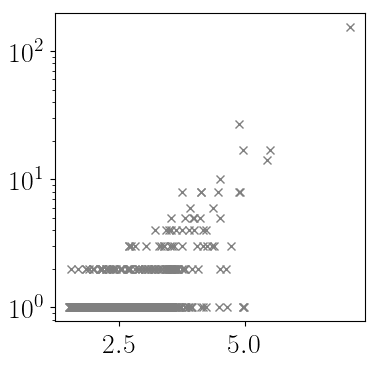

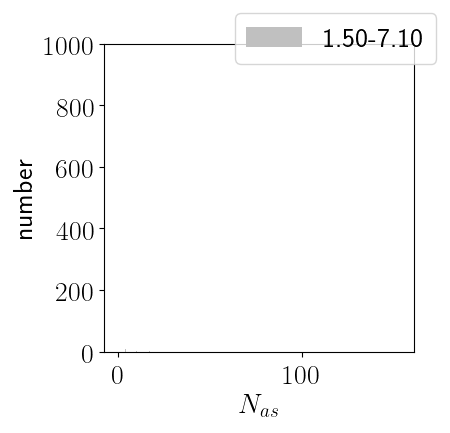

In [82]:
#--- number distributions


#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)



#--- remove pairs with r > cs.t
#cs = 3 * (24*3600) #--- km per day
df_trig = nij_trig.copy()

#--- parents' magnitudes
m_list = GetParentsMagnitudes( swarm_lohi, df_trig )

#--- number of daughters for each mother
df_nn = df_trig.groupby(by='Parent_id').count()['Event_id']


#--- include daughters with zero children
list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)

#--- scattered plot
fig = plt.figure(figsize=(4,4),frameon=True)
ax = fig.add_subplot(111)
ax.plot( swarm_lohi['magnitude'].loc[df_nn.index],
           df_nn,
          'x',color='gray',alpha=1.0)
ax.plot( swarm_lohi['magnitude'].loc[df_zeros.index],
         df_zeros,
          'x',color='gray')
ax.set_yscale('log')


#--- parents' magnitudes
m_list = GetParentsMagnitudes( swarm_lohi, df_trig )

#--- number of daughters for each mother
df_nn = df_trig.groupby(by='Parent_id').count()['Event_id']


#--- include daughters with zero children
list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)


#--- scattered plot
m_min = min(m_list)-1e-6 #0.05 #-1.0e-6
m_max = max(m_list)+1.0e-6 #3.299999333333333 #max(m_list)+0.05 #+1.0e-6 #--- exclude the largest event

#--- choose m0<m<m1
dm = 0.4
n = int( ( m_max - m_min ) / dm )
m = [m_min,m_max] #list(np.linspace(m_min,m_max,n+1))
Mlist=m

m_mean=np.array(np.zeros(len(m) - 1))
m_err=np.array(np.zeros(len(m) - 1))
N_as = np.array(np.zeros(len(m) - 1))
err_N = np.array(np.zeros(len(m) - 1))
for i in xrange(len(m) - 1 ):
    try:
        m0 = m[ i ]
        m1 = m[ i + 1 ]
        df, m_mean[ i ], m_err[i] = GetPairsWithSpecifiedParentMag((m0,m1),
                                                         swarm_lohi,df_trig) #--- get parent with m0<m<m1
        df.reset_index( inplace = True, drop = True )
        
        #--- number of daughters for each mother
        df_n = df.groupby(by='Parent_id').count()['Event_id']
    
        #--- include daughters with zero children
        list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
        subset = swarm_lohi.loc[list_of_zero_afs]
        list_of_zero_afs = subset[(subset['magnitude'] >= m0) & (subset['magnitude'] <= m1)].index    
        df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
        
#        fig.hist(df_n)
#        if m1 > 3.3:
#            continue
        fig = plt.figure(figsize=(4,4),frameon=True)
        ax = fig.add_subplot(111)
        junk = ax.hist( df_n.tolist()+df_zeros.tolist(),
                bins=1024,#int((xmax-xmin)/dx),
               label='%3.2f-%3.2f'%(m0,m1),color='silver') #--- histogram
        print '#=',junk[0][junk[0]!=0]
        print 'N=',junk[1][:-1][junk[0]!=0]
        ax.set_xlabel('$N_{as}$')
        ax.set_ylabel('number')
#        ax.set_ylim(-100,ax.axis[3])
        fig.legend()
        #--- mean
#        print [m0,m1],list_of_zero_afs
#        pdb.set_trace()
        print 'n_ms=',len(df_n)#+len(df_zeros)
        print 'n_ms(0)=',len(df_zeros)
        N_as[ i ] = 1.0*(df_n.sum()+ df_zeros.sum())/(len(df_n)+len(df_zeros))
        err_N[ i ] = (N_as[ i ]/(len(df_n)+len(df_zeros)))**0.5 #--- poisson
#        err_N[ i ]=np.std(df_n.tolist()+df_zeros.tolist())/(len(df_n)+len(df_zeros))**0.5
    except:
        continue
    

[0.01312564 0.56332433]
[[0.00566745        nan]
 [       nan 0.03831149]]


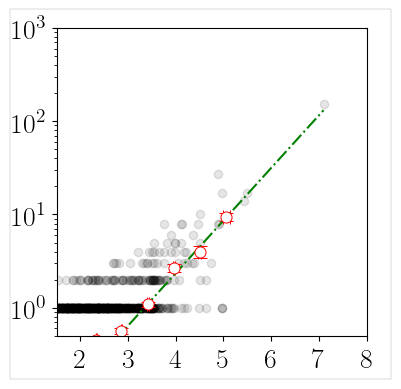

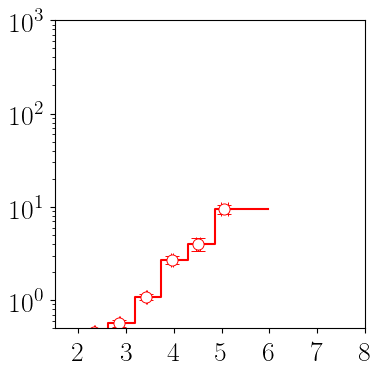

In [83]:
#--- choose bins for rho and lambda

import traceback

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)



#--- remove pairs with r > cs.t
#cs = 3 * (24*3600) #--- km per day
df_trig = nij_trig.copy()

#--- parents' magnitudes
m_list = GetParentsMagnitudes( swarm_lohi, df_trig )

#--- number of daughters for each mother
df_nn = df_trig.groupby(by='Parent_id').count()['Event_id']


#--- include daughters with zero children
list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)


#--- scattered plot
fig = plt.figure(figsize=(4,4),frameon=True)
ax = fig.add_subplot(111)
#ax.set_xlim(mc,swarm_lohi['magnitude'].max()+0.5)
m_min = min(m_list)-1.0e-6
m_max = max(m_list)+1.0e-6 #--- exclude the largest event
ax.set_xlim(m_min,np.ceil(m_max))
ax.set_ylim(0.5,1000)
ax.plot( swarm_lohi['magnitude'].loc[df_nn.index],
           df_nn,
          'o',color='black',alpha=.1)
ax.plot( swarm_lohi['magnitude'].loc[df_zeros.index],
         df_zeros,
          'x',color='gray')

plt.yscale('log')
#plt.xlabel('$m$')
#plt.ylabel(r'$N_{as}$')

#--- choose m0<m<m1
dm = 0.5
n = int( ( m_max - m_min ) / dm )
m = list(np.linspace(m_min,m_max,n))
m=AdjustBins(m_list,m)
# m=[2.7999989999999997,
#  3.133332555555555,
#  3.466666111111111,
#  3.7999996666666664,
#  4.133333222222222,
#  4.466666777777778,
#  4.800000333333333,
#  5.800001]
Mlist=m

m_mean=np.array(np.zeros(len(m) - 1))
m_err=np.array(np.zeros(len(m) - 1))
N_as = np.array(np.zeros(len(m) - 1))
err_N = np.array(np.zeros(len(m) - 1))
for i in xrange( len(m) - 1 ):
    try:
        m0 = m[ i ]
        m1 = m[ i + 1 ]
        df, m_mean[ i ], m_err[i] = GetPairsWithSpecifiedParentMag((m0,m1),
                                                         swarm_lohi,df_trig) #--- get parent with m0<m<m1
        df.reset_index( inplace = True, drop = True )
#        pdb.set_trace()
        #--- number of daughters for each mother
        df_n = df.groupby(by='Parent_id').count()['Event_id']
    
        #--- include daughters with zero children
        list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
        subset = swarm_lohi.loc[list_of_zero_afs]
        list_of_zero_afs = subset[(subset['magnitude'] >= m0) & (subset['magnitude'] <= m1)].index    
        df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
        #--- mean
#        print [m0,m1],list_of_zero_afs
#        pdb.set_trace()
        
        N_as[ i ] = 1.0*(df_n.sum()+ df_zeros.sum())/(len(df_n)+len(df_zeros))
        err_N[ i ] = (N_as[ i ]/(len(df_n)+len(df_zeros)))**0.5 #--- poisson
#        err_N[ i ]=np.std(df_n.tolist()+df_zeros.tolist())/(len(df_n)+len(df_zeros))**0.5
    except:
#        traceback.print_exc()
        continue
    
#ax.plot(m, np.append(N_as,N_as[-1]), linestyle='-', drawstyle='steps-post',color='red')
ax.errorbar(m_mean,N_as,
            yerr=err_N,xerr=m_err,
            markerfacecolor='white',
            fmt='o', markersize=8,color='red',markeredgewidth=0.7,
            linewidth=.5,
            barsabove=None,capsize=5,capthick=1,elinewidth=1)


#--- add major xticks
xmin=np.ceil(ax.axis()[0])
xmax=np.floor(ax.axis()[1])
nbin = xmax - xmin
ax.set_xticks(np.linspace(xmin,xmax,int(nbin)+1))

DrawFrame(ax, (0.15,0.08),(0.14,0.06),0.1,LOG_Y=True)

try:
    from scipy.optimize import curve_fit
    def func(x,c,alpha):
        return c*10**(alpha*x)
    popt, pconv = curve_fit(func,m_mean[m_mean>=mc],N_as[m_mean>=mc])
    
    mm = swarm_lohi['magnitude'].loc[df_zeros.index].tolist() + \
         swarm_lohi['magnitude'].loc[df_nn.index].tolist() #swarm_lohi[swarm_lohi['magnitude']>=mc]['magnitude']
    mm = np.array(mm)
    mm=list(set(mm))
    mm.sort()
    mm=np.array(mm)
    ax.plot(mm,func(mm,*popt),'-.g')
    print popt
    print pconv**0.5
except:
    pass

plt.savefig('%s/prod.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')


fig = plt.figure(figsize=(4,4),frameon=True)
ax = fig.add_subplot(111)
ax.plot(m, np.append(N_as,N_as[-1]), linestyle='-', drawstyle='steps-post',color='red')
ax.errorbar(m_mean,N_as,
            yerr=err_N,xerr=m_err,
            markerfacecolor='white',
            fmt='o', markersize=8,color='red',markeredgewidth=0.7,
            linewidth=.5,
            barsabove=None,capsize=5,capthick=1,elinewidth=1)
ax.set_xlim(m_min,np.ceil(m_max))
ax.set_ylim(0.5,1000)
ax.set_yscale('log')
ax.set_xticks(np.linspace(xmin,xmax,int(nbin)+1))

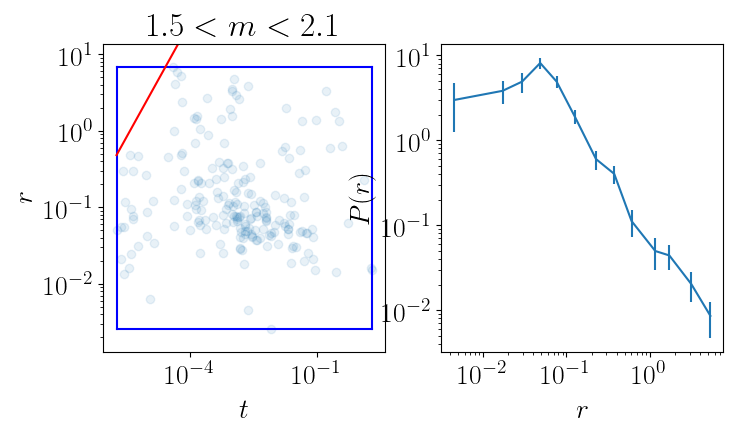

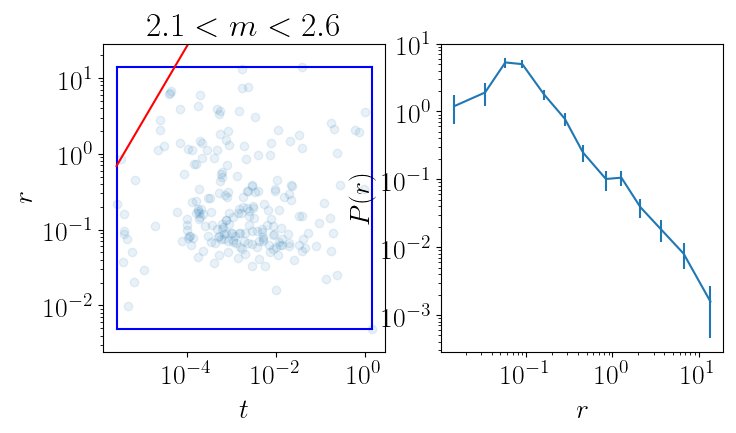

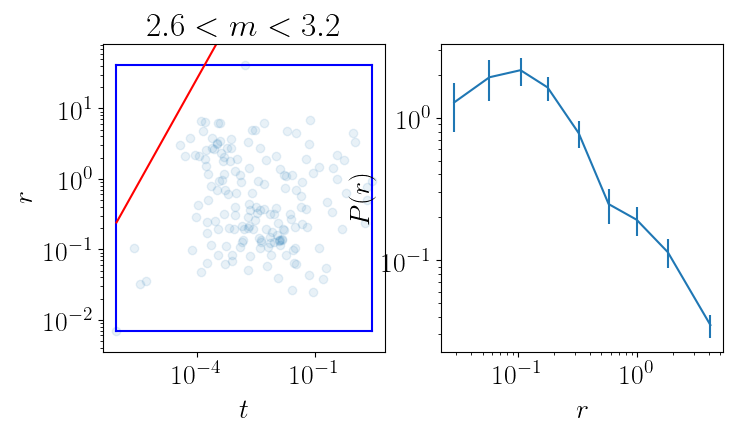

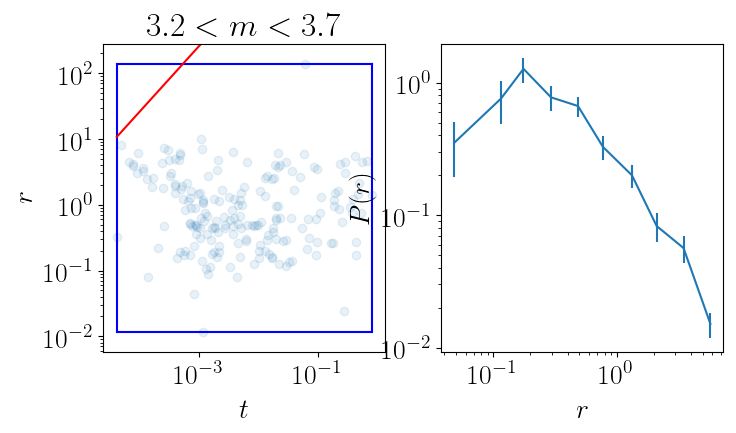

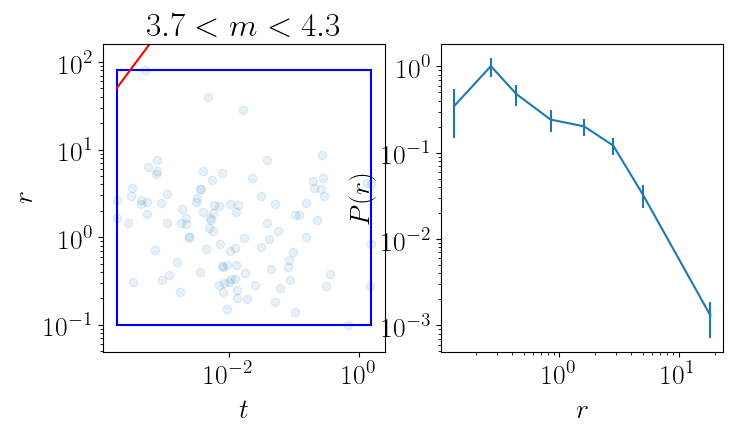

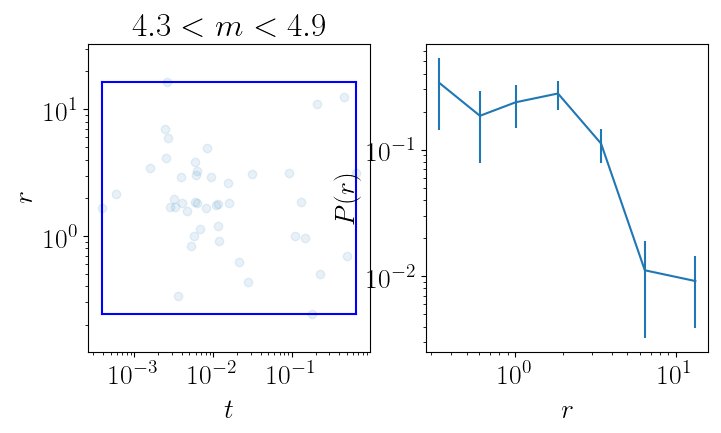

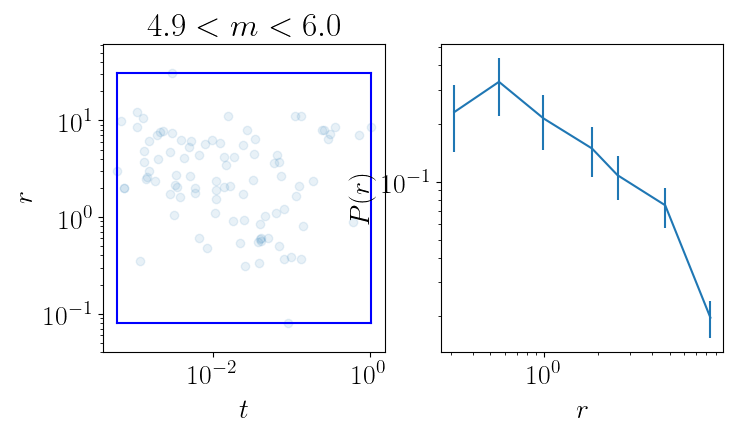

In [84]:
#--- density plots: rho(r)
#--- split based on the mainshock's magnitude

import numpy as np
import math

#def AdjustBins(data,bins):
#    hist, xedges=np.histogram(data, #--- histogram
#                              bins=bins)
#    tmp = [xedges[0]]
#    for i,j in zip(xedges[1:],hist): #--- expand bins 
#        if j < 2:
#            continue
#        tmp.append(i)
#    tmp.append(xedges[-1])
#    if hist[-1] < 2:
#        tmp.pop(-2)
#    return tmp 

#def GetPairsWithSpecifiedParentMag((m0,m1),catalog,df):
#    df_parents = df.groupby(by='Parent_id').groups #--- parent events
#    ds = catalog['magnitude'].loc[df_parents.keys()] #--- mag. of parent events
#    ds_m=ds[(m0 <= ds) & (ds < m1)] #--- parent events with m0<m<m1
#    df_m=df[pd.DataFrame([df['Parent_id'] ==k for k in ds_m.index]).any()] #--- data frame
#    return df_m, np.mean( ds_m )

#def AddDist( df_trig, df_complete ):
#    x=df_complete.loc[ df_trig['Event_id'] ]['r(m)'] 
#    y=df_complete.loc[ df_trig['Parent_id'] ]['r(m)']
#    df_trig['R'] = pd.Series(numpy.linalg.norm(x-y)))
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )

def AddTime( df_trig, df_complete ):
    prefact = 1.0 / ( 24.0 * 60 * 60 ) #--- daily
    x=df_complete.loc[ df_trig['Event_id'] ]
    y=df_complete.loc[ df_trig['Parent_id'] ]
    x.reset_index(inplace=True)
    y.reset_index(inplace=True)
    df_trig['T'] = x['date']-y['date']
    df_trig['T'] = df_trig['T'].apply(lambda x: x.total_seconds() * prefact)

def RemovePair( df, cs ):
    return df [ df[ 'R' ] <= df[ 'T' ] * cs ]

#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

##--- parents' magnitudes
#df_trig = nij_trig.copy()
#m_list = GetParentsMagnitudes( swarm_lohi, df_trig )
#m_min = min(m_list)-1.0e-6
#m_max = max(m_list)+1.0e-6 #--- exclude the largest event
#
##--- choose m0<m<m1
#dm = 0.3
#n = int( ( m_max - m_min ) / dm )
#m = list(np.linspace(m_min,m_max,n))
#m=AdjustBins(m_list,m)
Mlist=m

#--- choose m0<m<m1
X={}
rho_dict={}
m_range={}
Err={}
m_mean={}
for i in xrange( len(m) - 1 ):
    m0 = m[ i ]
    m1 = m[ i + 1 ]
    
    df_trig, m_mean[ i ],junk = GetPairsWithSpecifiedParentMag((m0,m1),swarm_lohi,nij_trig) #--- get parent with m0<m<m1
    df_trig.reset_index( inplace = True, drop = True )
    
    #--- add distance & time column
#    AddDist( df_trig, df_complete )
#    df_trig['R'] = rmat[df_trig['Parent_id'],df_trig['Event_id']]
#    df_trig['T'] = tmat[df_trig['Parent_id'],df_trig['Event_id']]
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )
#    AddTime( df_trig, df_complete )
    
    #--- remove pairs with r > cs.t
#    cs = 3 * (24*3600) #--- km per day
#    df_trig = RemovePair( df_trig, cs )

    #--- rho plots
    n_decades = int( math.ceil( log(df_trig['R'].max()/df_trig['R'].min(),10) ) )
    nbin_per_decade = 4
    nbins =  nbin_per_decade * n_decades
    
    bins = np.logspace(log(df_trig['R'].min(),10)-1.e-10,
                                              log(df_trig['R'].max(),10)+1.e-10,nbins)
    bins = AdjustBins(df_trig['R'],bins)

    rho, xedges=np.histogram(df_trig['R'], 
                             density=True,
                             bins=bins)
    hist, xedges=np.histogram(df_trig['R'],
                              bins=bins)
    x_bins, junk=np.histogram(df_trig['R'], #--- histogram
                              bins=bins,
                             weights = df_trig['R'])

    #--- rm empty bins
    x_bins = x_bins[ hist != 0 ]
    rho = rho[ hist != 0 ]
    hist = hist[ hist != 0 ]
    
    #--- poisson err 
    err = rho/np.sqrt(hist)
    x_bins /= hist
            
    #--- scattered plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title('$%2.1f<m<%2.1f$'%(m0,m1))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$t$')
    plt.ylabel('$r$')
    #plt.xlim(1e-3,100)
    #plt.ylim(1e-3,1e2)
    plt.scatter(df_trig['T'],df_trig['R'],alpha=0.1)
    
    #--- discretization effects
    dt_min=df_trig['T'].min()
    dt_max=df_trig['T'].max()
    dr_min=df_trig['R'].min()
    dr_max=df_trig['R'].max()
    
    plt.plot([dt_min,dt_min],[dr_min,dr_max],
             '-',color='blue')
    plt.plot([dt_max,dt_max],[dr_min,dr_max],
             '-',color='blue')
    plt.plot([dt_min,dt_max],[dr_min,dr_min],
             '-',color='blue')
    plt.plot([dt_min,dt_max],[dr_max,dr_max],
             '-',color='blue')
    
    plt.ylim(dr_min/2,dr_max*2)
    plt.plot([dt_min,dt_max],[dt_min*cs,dt_max*cs],
             '-',color='red')
    
    #--- rho
    plt.subplot(1,2,2)
#    plt.xlim(1e-3,1e2)
#    plt.ylim(1e-3,1e2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$r$')
    plt.ylabel('$P(r)$')
    plt.errorbar(x_bins,rho, yerr=err)
        
    X[i] = x_bins[:]
    rho_dict[i]=rho[:]
    m_range[i]=np.array([m0,m1])
    Err[i]=err[:]

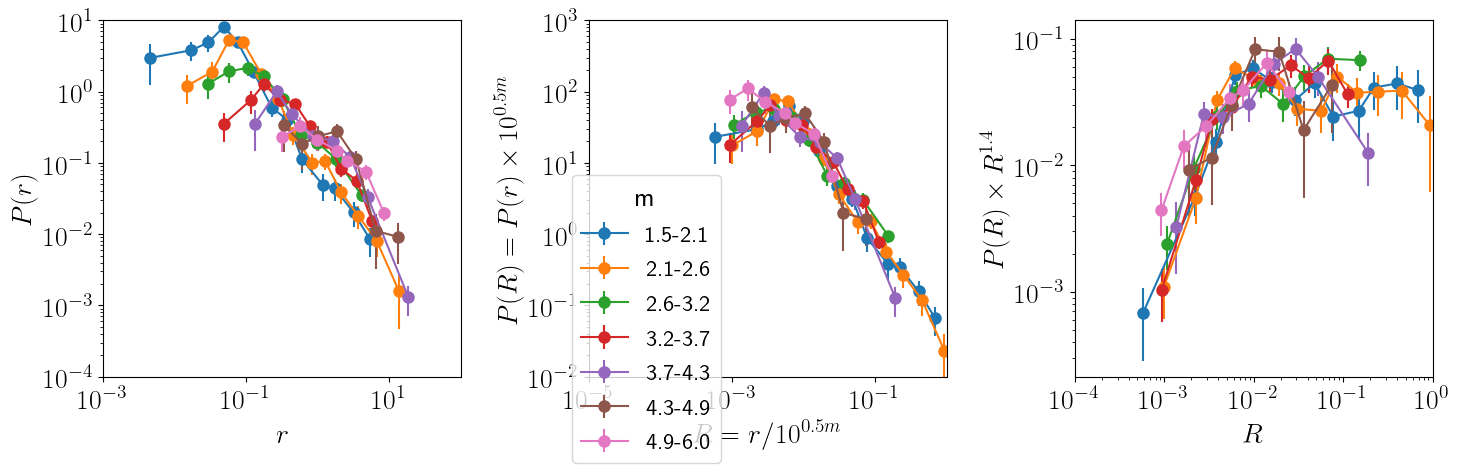

In [85]:
#--- density plots: rho(r) 2nd


plt.figure(figsize=(15,5))

#--- plot rho
plt.subplot(1,3,1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.xlim(1e-3,1e2)
plt.ylim(1e-4,1e1)
for key in X:
#    if key < 3:
#        continue
    plt.errorbar(X[key],rho_dict[key],
                 yerr=Err[key],
                 fmt='-o', markersize=8
                )

#--- rescaled in x and y
plt.subplot(1,3,2)
alpha=0.5
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$R=r/10^{%s m}$'%alpha)
plt.ylabel(r'$P(R)=P(r)\times 10^{%s m}$'%alpha)
plt.xlim(1e-5,1e0)
plt.ylim(1e-2,1e3)

xdata = []
ydata = []
for key in X:
#    if key < 3:
#        continue
    xdata += list(X[key]/10**(alpha*np.mean(m_range[key])))
    ydata += list(rho_dict[key]*10**(alpha*np.mean(m_range[key])))
    
    plt.errorbar(X[key]/10**(alpha*m_mean[key]),
                 rho_dict[key]*10**(alpha*m_mean[key]),
                 yerr=Err[key]*10**(alpha*m_mean[key]),
                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 fmt='-o', markersize=8
                )
plt.legend(title='m',prop=fontP,loc='upper right',bbox_to_anchor=(0.4, .6))

#--- rescaled by r^-\nu
nu = 1.4 #2.9
plt.subplot(133)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$R$')
plt.ylabel(r'$P(R)\times R^{%s}$'%nu)
#plt.ylabel(r'$\lambda(t) \times t^p$')
plt.xlim(1e-4,1e0)
#plt.ylim(1e-3,1e5)
KEYS=X.keys()
KEYS.sort()
for key, index in zip(KEYS,xrange(100)):
#    if key < 3:
#        continue
    x_new = X[key]/10**(alpha*m_mean[key])
    y_new = rho_dict[key]*10**(alpha*m_mean[key])
    y2_new = Err[key]*10**(alpha*m_mean[key])
    plt.errorbar(x_new,
                 y_new*x_new**nu,
                 yerr=y2_new*x_new**nu, 
                 fmt='-o', markersize=8
                )
    
    
plt.tight_layout()
plt.savefig('%s/rho_r.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')


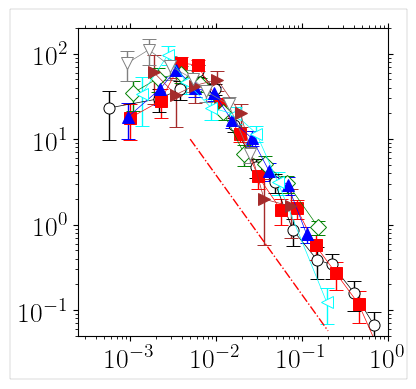

In [86]:
#--- density plots: rho(r) (paper version)

import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.ticker

#rc('text', usetex=True)
#font = {'size'   : 20}
#matplotlib.rc('font', **font)
#plt.style.use('seaborn')
#plt.rcParams.update({'lines.markeredgewidth': 1})

def returnCMtoInch(x,y):
    return (x/2.54,y/2.54)

fig, ax = plt.subplots(figsize=(4,4))
sigma=alpha
ax.axis([1/(200/5e-2),1,5e-2,200])
ax.loglog()

#--- add major xticks
xmin=np.ceil(np.log10(ax.axis()[0]))
xmax=np.floor(np.log10(ax.axis()[1]))
nbin = xmax - xmin
ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))

#--- put minor bins
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#plt.xlabel(r'$R=r/10^{%s m}$'%alpha)
#plt.ylabel(r'$P(R)=P(r)\times 10^{%s m}$'%alpha)


xdata = []
ydata = []
colors = ['black','red','green','blue','cyan','brown','grey']
fillstyles=['white',None,'white',None,'white',None,'white',None]
markers=['o','s','D','^','<','>','v']
assert len(colors) >= len(X)
for key,col,mk,fl in zip(X,colors,markers,fillstyles):
    xdata += list(X[key]/10**(sigma*np.mean(m_range[key])))
    ydata += list(rho_dict[key]*10**(sigma*np.mean(m_range[key])))
    
    ax.errorbar(X[key]/10**(sigma*m_mean[key]),
                 rho_dict[key]*10**(sigma*m_mean[key]),
                 yerr=Err[key]*10**(sigma*m_mean[key]),
                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 fmt='-o', markersize=8,color=col,marker=mk,markerfacecolor=fl,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1
                )
#fig.legend(title='m',prop=fontP,loc='upper right',frameon=False)#, bbox_to_anchor=(0.4, .6))
ax.tick_params(axis='y',left=True, right=True,which='both')
ax.tick_params(axis='x',bottom=True, top=True,which='both')

nu=-1.4
ax.plot([5e-3,.2],[10, 10* (.2/5e-3)**nu],'r-.',linewidth=1)

##--- rescaled by r^-\nu
#nu = 2.8
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel(r'$R$')
#plt.ylabel(r'$P(R)\times R^{%s}$'%nu)
##plt.ylabel(r'$\lambda(t) \times t^p$')

#KEYS=X.keys()
#KEYS.sort()
#for key, index in zip(KEYS,xrange(100)):
##    if key < 3:
##        continue
#    x_new = X[key]/10**(alpha*m_mean[key])
#    y_new = rho_dict[key]*10**(alpha*m_mean[key])
#    y2_new = Err[key]*10**(alpha*m_mean[key])
#    plt.errorbar(x_new,
#                 y_new*x_new**nu,
#                 yerr=y2_new*x_new**nu, 
#                 fmt='-o', markersize=8
#                )

    
    
DrawFrame(ax, (0.22,0.06),(0.14,0.06),0.1,LOG_X=True,LOG_Y=True)


#plt.tight_layout()
plt.savefig('%s/rho_r.png'%DIR_OUTPT_figs,dpi=300,bbox_inches='tight')


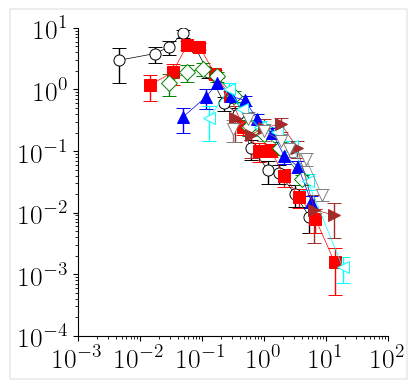

In [46]:
#--- density plots: rho(r) (paper version 2nd)

#plt.style.use('seaborn')
#plt.rcParams.update({'lines.markeredgewidth': 1})

def returnCMtoInch(x,y):
    return (x/2.54,y/2.54)

fig, ax = plt.subplots(figsize=(4,4))
#---
ax.spines['right'].set_visible(False) #--- half open
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#---
ax.axis([1e-3,1e2,1e-4,1e1])
ax.loglog()
#ax.set_xticks(np.logspace(-1,3,4))

#--- add major xticks
xmin=np.ceil(np.log10(ax.axis()[0]))
xmax=np.floor(np.log10(ax.axis()[1]))
nbin = xmax - xmin
ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))

#--- put minor bins
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


#plt.xlabel(r'$R=r/10^{%s m}$'%alpha)
#plt.ylabel(r'$P(R)=P(r)\times 10^{%s m}$'%alpha)
#plt.xlim(1e-5,1e0)
#plt.ylim(1e-5,1e0)

#colors = ['black','red','green','blue','cyan','brown']
#fillstyles=['white',None,'white',None,'white',None,'white']
#markers=['o','s','D','^','<','v']
#assert len(colors) >= len(X)
for key,col,mk,fl in zip(X,colors,markers,fillstyles):
    ax.errorbar(X[key],
                 rho_dict[key],
                 yerr=Err[key],
                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 fmt='-o', markersize=8,color=col,marker=mk,markerfacecolor=fl,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1
                )

    #fig.legend(title='m',prop=fontP,loc='lower left',frameon=False)#, bbox_to_anchor=(0.4, .6))
#ax.tick_params(axis='y',left=True, right=True,which='both')
#ax.tick_params(axis='x',bottom=True, top=True,which='both')
DrawFrame(ax, (0.22,0.06),(0.14,0.06),0.1,LOG_X=True,LOG_Y=True)


#plt.tight_layout()
plt.savefig('%s/rho_r.png'%DIR_OUTPT_figs,dpi=300,bbox_inches='tight',transparent=True)


In [ ]:
m_mean

[6.4846420e-04 6.8940465e-01]
[[inf inf]
 [inf inf]]


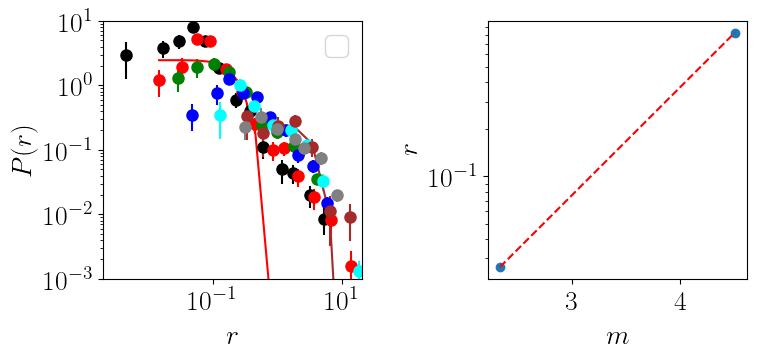

In [54]:
from scipy.optimize import curve_fit

def func(x,pref, xmean,sigma):
    return pref * np.exp(-((x-xmean)/sigma)**2)

fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(121)
ax.axis([2e-3,2e-3*1e1/1e-3,1e-3,1e1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$r$')
ax.set_ylabel('$P(r)$')


r_peak={}
mm_mean={}
#colors = ['black','red','green','blue','cyan','brown']
#assert len(colors) >= len(X)
p0 = (1.0,0.05,.1)
for key, col in zip(X,colors):
    try:
#        print np.mean(X[key])
        ax.errorbar(X[key],rho_dict[key], 
                     yerr=Err[key],
                    linestyle='None', color=col,
                     fmt='-o', markersize=8
                    )            
        popt, pcov = curve_fit(func, X[key], rho_dict[key],
                               sigma=Err[key], 
                               p0=p0) #, bounds=((0.0,0.0), (np.inf,10.0)))
        mm_mean[key]=m_mean[key]
        p0 = popt[:]
#        print p0
        r_peak[key] = popt[1]
    #    if key == 5:
        ax.plot(X[key], func(X[key], *popt),'-',color=col)#,label='fit: r=%3.2f' % (popt[1]))
        ax.legend()
    except:
        continue

ax=fig.add_subplot(122)
ax.set_yscale('log')
ax.set_xlabel('$m$')
ax.set_ylabel('$r$')
#ax.set_ylim(1,1e3)
ax.plot(mm_mean.values(),r_peak.values(),'o')
#
#
def func(x,c,alpha):
    return c*10**(alpha*x)
#
popt, pconv = curve_fit( func, mm_mean.values(),r_peak.values() )
#
ax.plot(mm_mean.values(),func( np.array(mm_mean.values()),*popt),'--r')
print popt
print pconv**0.5

fig.tight_layout()

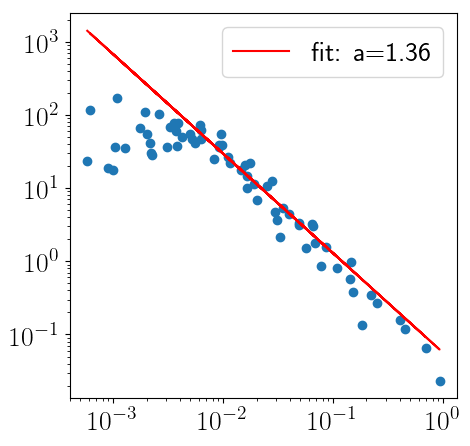

In [48]:
#--- fitting

from scipy.optimize import curve_fit

def func(x,a,b):
    return a/x**b

xdata = np.array(xdata)
xxdata = xdata[xdata>1e-2]
ydata = np.array(ydata)
yydata = ydata[xdata>1e-2]

popt, pcov = curve_fit(func, xxdata, yydata, p0=(1.0,3.0), bounds=((0.0,0.0), (np.inf,10.0)))

plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-1,1e2)
#plt.ylim(1e-4,1e-1)
plt.plot(xdata, ydata,marker='o',linestyle='None')
plt.plot(xdata, func(xdata, *popt),'r-',label='fit: a=%3.2f' % popt[1])
plt.legend()         
#plt.plot(xdata, func(xdata, *popt), 'g--',
#         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))


# of mother events:201
N_as=0.6129032258064516
# of mother events:201
N_as=0.8164794007490637
# of mother events:138
N_as=0.9881656804733728
# of mother events:134
N_as=1.3873239436619718
# of mother events:34
N_as=2.9166666666666665
# of mother events:11
N_as=4.0
# of mother events:9
N_as=10.444444444444445


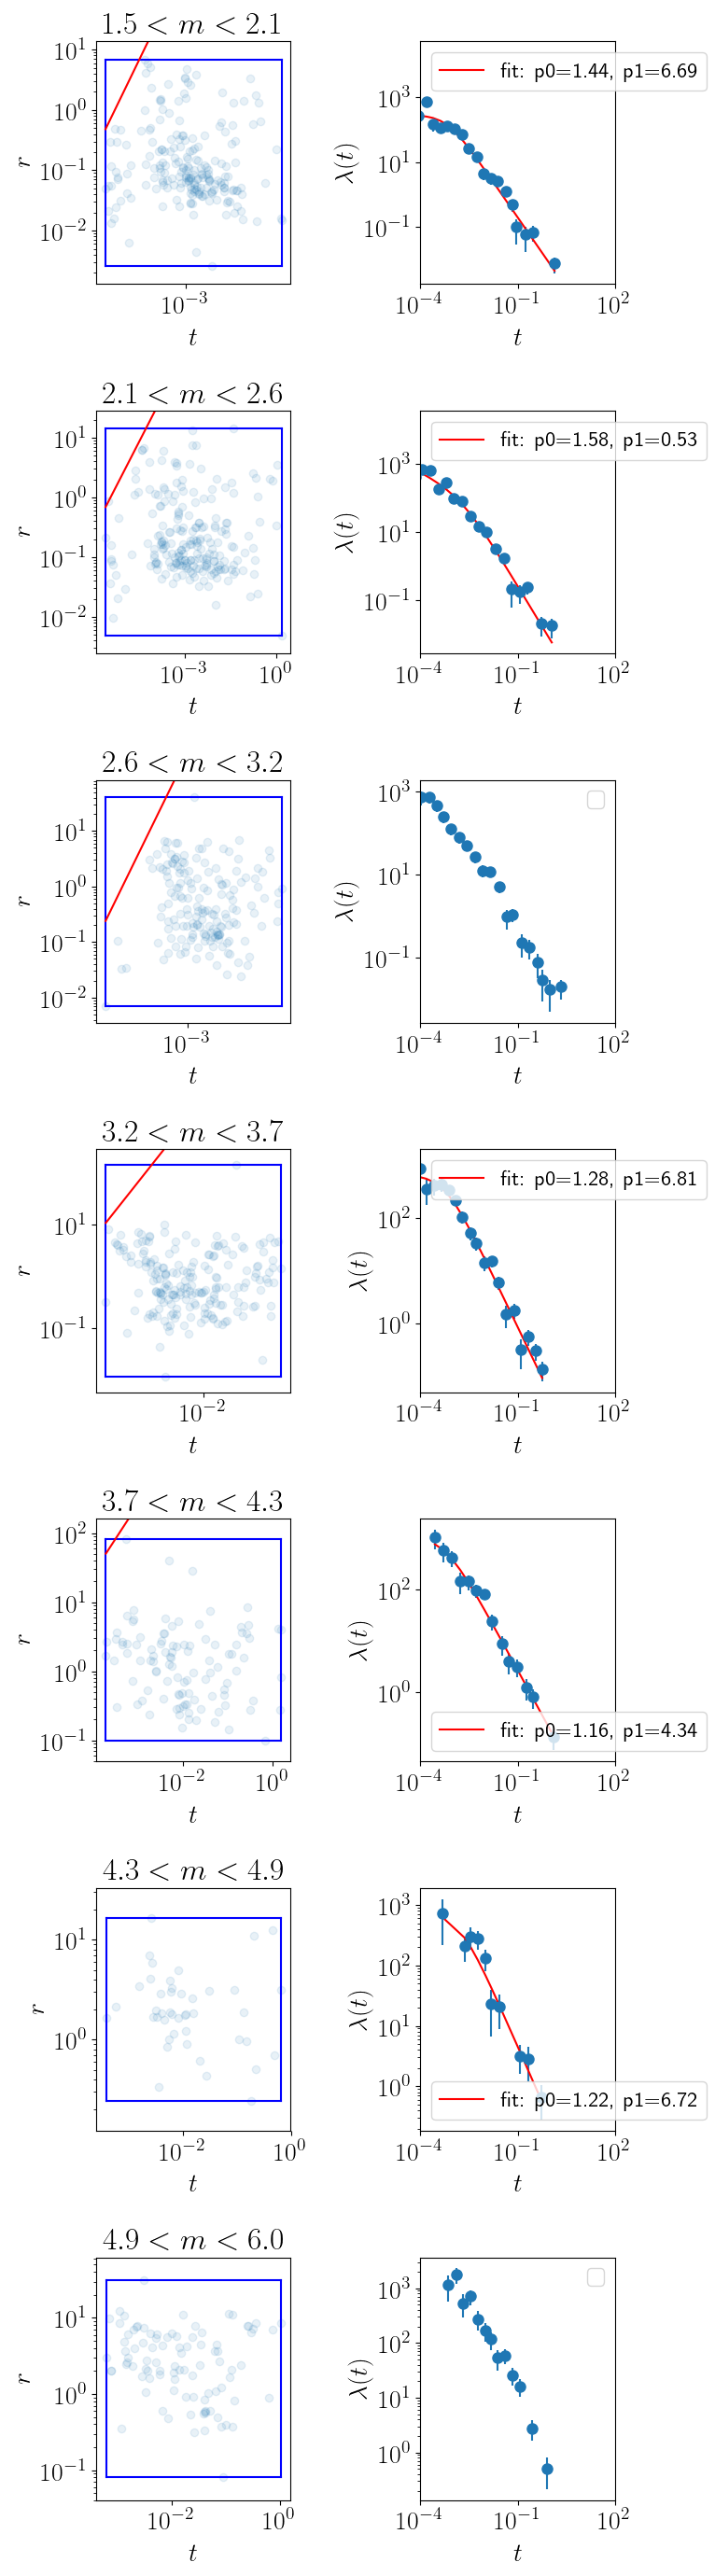

In [87]:
#--- omori relation

import numpy as np
import math
from scipy.optimize import curve_fit

#def func(x,c,p,A):#,B):
#    return A/(1+x/c)**p

def func(x,c,p,A,c2,p2):#,B):
    return A/(1+(x/c)**p+(x/c2)**p2)


#def func(x,c,p):#,B):
#    return (p-1)/c/(1+x/c)**p



#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

popt={}
pcov={}
perr = {}

##--- parents' magnitudes
#m_list = GetParentsMagnitudes( swarm_lohi, df_trig )
#m_min = min(m_list)-1.0e-6
#m_max = max(m_list)+1.0e-6 #--- exclude the largest event
#
##--- choose m0<m<m1
#dm = 0.3
#n = int( ( m_max - m_min ) / dm )
#m = list(np.linspace(m_min,m_max,n))
#m=AdjustBins(m_list,m)
#Mlist=m



X={}
rho_dict={}
#m_range={}
Err={}
m_mean=np.array(np.zeros(len(m)-1))
Xedges={}
nrows=len(m)-1;ncols=2
fig=plt.figure(figsize=(ncols*4,nrows*4))


for i in xrange( len(m) - 1 ):
#    if i == (len(m) - 2):
#        pdb.set_trace()
    m0 = m[ i ]
    m1 = m[ i + 1 ]
    
    df_trig,m_mean[ i ],junk = GetPairsWithSpecifiedParentMag((m0,m1),swarm_lohi,nij_trig) #--- get parent with m0<m<m1
    df_trig.reset_index( inplace = True, drop = True )
    print "# of mother events:%s"%len(df_trig.groupby(by="Parent_id"))

    #--- number of daughters for each mother
    df_n = df_trig.groupby(by='Parent_id').count()['Event_id']
    
    #--- include daughters with zero children
    list_of_zero_afs = set(df_trig['Event_id'])-set(df_trig['Parent_id'])
    subset = swarm_lohi.loc[list_of_zero_afs]
    list_of_zero_afs = subset[(subset['magnitude'] >= m0) & (subset['magnitude'] <= m1)].index    
    df_zeros = pd.Series(np.zeros(len(list_of_zero_afs)),index=list_of_zero_afs)
    #--- mean
    N_as = 1.0*(df_n.sum()+ df_zeros.sum())/(len(df_n)+len(df_zeros))
    print 'N_as=%s'%N_as
    #--- add distance & time column
#    df_trig['R'] = rmat[df_trig['Parent_id'],df_trig['Event_id']]
#    df_trig['T'] = tmat[df_trig['Parent_id'],df_trig['Event_id']]
#    assert len ( df_trig[ df_trig['R'] == 0.0 ] ) == 0, '%s'%display( df_trig[ df_trig['R'] == 0.0 ] )
    
    #--- remove pairs with r > cs.t
#    cs = 3 * (24*3600) #--- km per day
#    df_trig = RemovePair( df_trig, cs )

    #--- rho plots
    n_decades = int( math.ceil( log(df_trig['T'].max()/df_trig['T'].min(),10) ) )
    nbin_per_decade = 4
    nbins =  nbin_per_decade * n_decades
    bins = np.logspace(log(df_trig['T'].min(),10)-1.e-10,
                                              log(df_trig['T'].max(),10)+1.e-10,nbins)
    bins = AdjustBins(df_trig['T'],bins)

    rho, xedges=np.histogram(df_trig['T'], #--- density
                             density=True,
                             bins=bins)
    rho *= N_as #--- int rho = N_as
    hist, xedges=np.histogram(df_trig['T'], #--- histogram
                              bins=bins)

    x_bins, junk=np.histogram(df_trig['T'], #--- histogram
                              bins=bins,
                             weights = df_trig['T'])

    #--- rm empty bins
    x_bins = x_bins[ hist != 0 ]
    rho = rho[ hist != 0 ]
    hist = hist[ hist != 0 ]
    
    #--- poisson err 
    err = rho/np.sqrt(hist)
    x_bins /= hist

    #---- fit    
#    fit = plfit.plfit( np.array(df_trig['T']) ) #--- clauset
#    cval = fit[1] #--- completeness mag.
#    pval = fit[0]
#    [pval, gof] = plpva.plpva(np.array(df_trig['T']), cval, 'xmin', cval,'silent')
#    print pval
    
    #--- 2nd fit
    try:
        popt[i], pcov[i] = curve_fit(func, x_bins, rho, 
                               p0=(1.0e-2,1.0,1e2,1e0,2.0), 
                               bounds=((1.0e-6,0.1,1e-5,1e-6,0.1), (np.inf,7,np.inf,np.inf,7)), #c,p,A,c2,p2
                               sigma=err #rho**0.5 #err
    #                           absolute_sigma = True,
    #                          method='trf'#'dogbox'
                              )
        perr[i] = np.sqrt(np.diag(pcov[i]))
    except:
        pass
    #--- scattered plot
    ax=fig.add_subplot(nrows,ncols,2*i+1)
    ax.set_title(r'$%2.1f<m<%2.1f$'%(m0,m1))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$r$')
    #plt.xlim(1e-3,100)
    #plt.ylim(1e-3,1e2)
    ax.scatter(df_trig['T'],df_trig['R'],alpha=0.1)
    
    #--- discretization effects
    dt_min=df_trig['T'].min()
    dt_max=df_trig['T'].max()
    dr_min=df_trig['R'].min()
    dr_max=df_trig['R'].max()
    
    ax.plot([dt_min,dt_min],[dr_min,dr_max],
             '-',color='blue')
    ax.plot([dt_max,dt_max],[dr_min,dr_max],
             '-',color='blue')
    ax.plot([dt_min,dt_max],[dr_min,dr_min],
             '-',color='blue')
    ax.plot([dt_min,dt_max],[dr_max,dr_max],
             '-',color='blue')
    
    ax.set_ylim(dr_min/2,dr_max*2)
    ax.plot([dt_min,dt_max],[dt_min*cs,dt_max*cs],
             '-',color='red')
    
    #--- rho
    ax=fig.add_subplot(nrows,ncols,2*i+2)
    ax.set_xlim(1e-4,1e2)
#    ax.set_ylim(1e-3,1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$\lambda(t)$')
    ax.errorbar(x_bins,rho, 
                 yerr=err,
                linestyle='None',
                 fmt='-o', markersize=8
                )
    
    #--- plot the fit
#    plt.plot(x_bins,
#             (pval-1)/cval/(1+x_bins/cval)**pval,
#             label='fit: p=%2.1f, c=%4.3f' % (pval,cval)
#            )
    #--- 2nd fit
    try:
        ax.plot(x_bins, func(x_bins, *popt[i]),'r-',label='fit: p0=%3.2f, p1=%3.2f' % (popt[i][1],popt[i][4]))
    except:
        pass
    fig.tight_layout()
    ax.legend(prop=fontP)#bbox_to_anchor=(1.5, 0.5))
    
    X[i] = x_bins[:]
    Xedges[i]=xedges
    rho_dict[i]=rho[:]
#    m_range[i]=np.array([m0,m1])
    Err[i]=err[:]
fig.savefig('%s/rho_t.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')

[9.21549587e-08 9.78036615e-01]


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

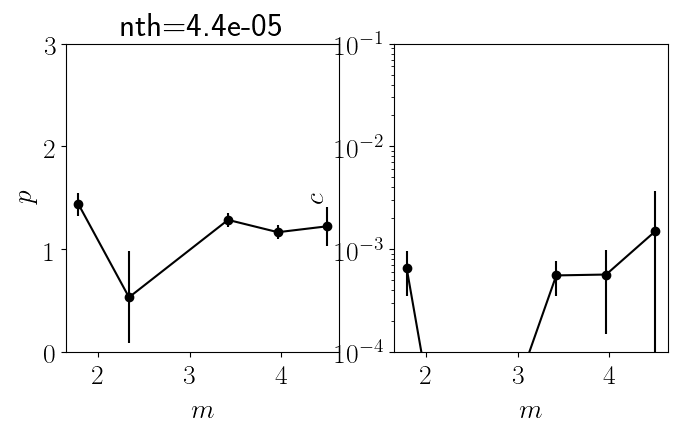

In [56]:
KEYS=popt.keys()
KEYS.sort()
M_Mean=[]
pval=[]
cval = []
cerr = []
aval = []
aerr = []
mm=[]
pperr=[]
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(131)
for ikey in KEYS: #--- exclude the last point
    pval.append( min(popt[ikey][1],popt[ikey][4]) )
    cval.append( min(popt[ikey][0],popt[ikey][3]) )
    aval.append( popt[ikey][2] )
    aerr.append(perr[ikey][2])
    index = min([popt[ikey][1],1],[popt[ikey][4],4])[1]
    pperr.append(perr[ikey][index])
    cerr.append(perr[ikey][index-1])
    M_Mean.append(m_mean[ikey])
ax.errorbar(M_Mean,pval,yerr=pperr,
            marker='o',color='black')
#ax.set_xlim(0,4)
ax.set_ylim(0,3)
ax.set_xlabel('$m$')
ax.set_ylabel('$p$')
ax.set_title('nth=%2.1e'%n_thresh)
#ax.plot([0,3],[1.29,1.29],'--r')
#ax.plot([0,3],[1.37,1.37],'--r')

#--- plot c 
def func(x,a,b):
    return a*10**(x*b)
poptt, pcovv = curve_fit(func, M_Mean,cval, sigma=cerr)
print poptt

ax2=fig.add_subplot(132)
ax2.set_ylim(1e-4,1e-1)
#ax2.set_xlim(0,4)
ax2.set_yscale('log')
ax2.set_ylabel('$c$')
ax2.set_xlabel('$m$')
ax2.errorbar(M_Mean,cval,yerr=cerr,
            marker='o',color='black')
ax2.plot(M_Mean,func(M_Mean,*poptt),'--r')

#--- plot A
poptt, pcovv = curve_fit(func, M_Mean,aval, sigma=aerr)
ax3=fig.add_subplot(133)
#ax3.set_ylim(1e2,1e4)
#ax3.set_xlim(0,4)
ax3.set_yscale('log')
ax3.set_ylabel('$A$')
ax3.set_xlabel('$m$')
ax3.errorbar(M_Mean,aval,yerr=aerr,
            marker='o',color='black')
ax3.plot(m_mean,func(M_Mean,*poptt),'--r')
print poptt

fig.tight_layout()
plt.savefig('%s/p.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')

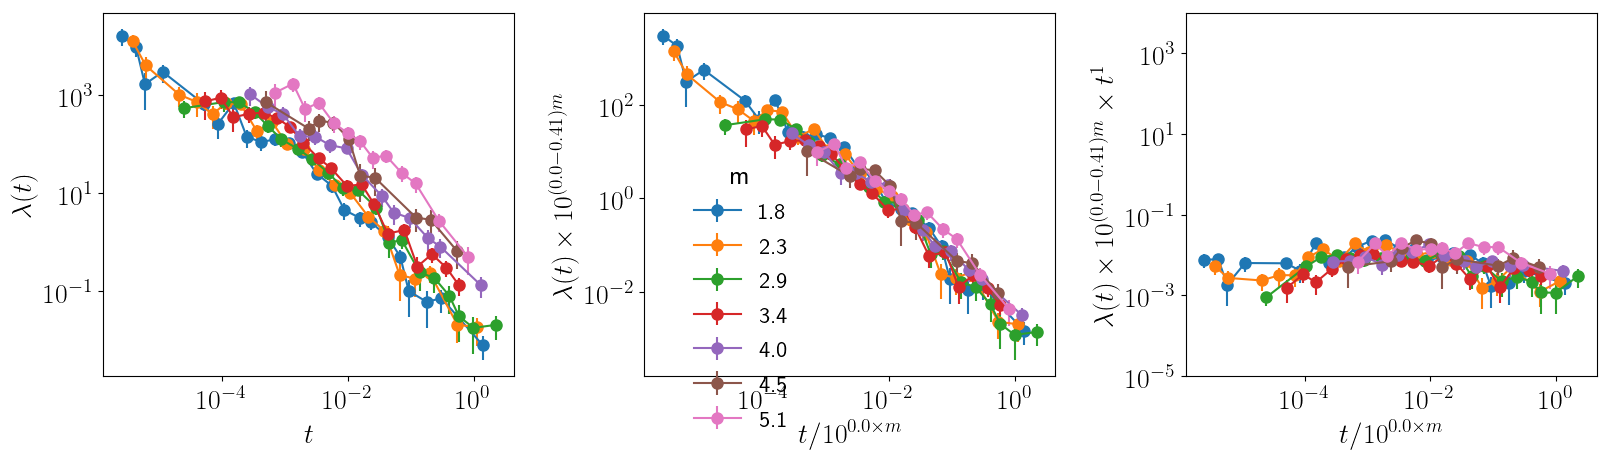

In [89]:
#--- omori relation


plt.figure(figsize=(16.5,5))


#--- unrescaled
plt.subplot(131)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$')
plt.ylabel('$\lambda(t)$')
#plt.xlim(1e-6,1e1)
#plt.ylim(1e0,1e7)
KEYS = X.keys()
KEYS.sort()
for key, index in zip(KEYS,xrange(100)):
    plt.errorbar(X[key],rho_dict[key],yerr=Err[key], 
#                label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),

                 fmt='-o', markersize=8
                )
#plt.legend(title='m',fontsize='small',loc='upper right',bbox_to_anchor=(0.4, .65),frameon=False)

#--- rescaled
alpha_c = 0.0 #0.5
alpha_p = 0.41 #--- productivity
alpha_y = alpha_c - alpha_p

plt.subplot(132)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t/10^{%s\times m}$'%alpha_c)
plt.ylabel(r'$\lambda(t) \times 10^{(%s-%s)m}$'%(alpha_c,alpha_p))
#plt.ylabel(r'$\lambda(t) \times t^p$')
#plt.xlim(1e-6,1e0)
#plt.ylim(1e-3,1e5)
for key, index in zip(KEYS,xrange(100)):
#    exp=1.1 #pval[key]
    plt.errorbar(X[key]/10**(alpha_c*m_mean[key]),
                 rho_dict[key]*10**(alpha_y*m_mean[key]),
                 yerr=Err[key]*10**(alpha_y*m_mean[key]), 
#                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 label='%2.1f'%(m_mean[key]),
                 fmt='-o', markersize=8
                )
plt.legend(title='m',fontsize='small',loc='upper right',bbox_to_anchor=(0.4, .65),frameon=False)

#--- rescaled by t^-p
p = 1

plt.subplot(133)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t/10^{%s\times m}$'%alpha_c)
plt.ylabel(r'$\lambda(t) \times 10^{(%s-%s)m} \times t^{%s}$'%(alpha_c,alpha_p,p))
#plt.ylabel(r'$\lambda(t) \times t^p$')
#plt.xlim(1e-6,1e0)
plt.ylim(1e-5,1e4)
for key, index in zip(KEYS,xrange(100)):
    x_new = X[key]/10**(alpha_c*m_mean[key])
    y_new = rho_dict[key]*10**(alpha_y*m_mean[key])
    y2_new = Err[key]*10**(alpha_y*m_mean[key])
    plt.errorbar(x_new,
                 y_new*x_new**p,
                 yerr=y2_new*x_new**p, 
                 fmt='-o', markersize=8
                )

plt.tight_layout()
plt.savefig('%s/rho_t_mult.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')

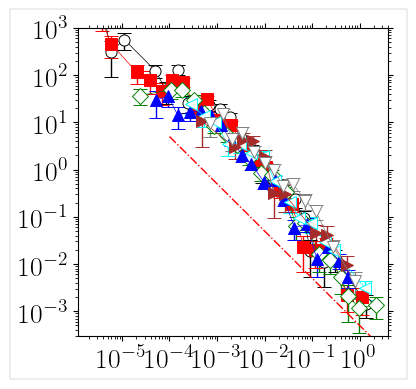

In [68]:
#--- omori (paper version)


#--- rescaled

fig, ax = plt.subplots(figsize=(4,4))
ax.axis([4/(1000/3e-4),4,3e-4,1000])
ax.loglog()

##--- add major xticks
xmin=np.ceil(np.log10(ax.axis()[0]))
xmax=np.floor(np.log10(ax.axis()[1]))
nbin = xmax - xmin
ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))

#--- add major yticks
ymin=np.ceil(np.log10(ax.axis()[2]))
ymax=np.floor(np.log10(ax.axis()[3]))
nbin = ymax - ymin
ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))

#--- put minor bins
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#--- put minor bins y
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


#xdata = []
#ydata = []
#colors = ['black','red','green','blue','cyan','brown']
#fillstyles=['white',None,'white',None,'white',None,'white']
#markers=['o','s','D','^','<','v']
#assert len(colors) >= len(X)
for key,col,mk,fl in zip(X,colors,markers,fillstyles):
#    xdata += list(X[key]/10**(alpha*np.mean(m_range[key])))
#    ydata += list(rho_dict[key]*10**(alpha*np.mean(m_range[key])))
    
    ax.errorbar(X[key]/10**(alpha_c*m_mean[key]),
                 rho_dict[key]*10**(alpha_y*m_mean[key]),
                 yerr=Err[key]*10**(alpha_y*m_mean[key]), 
                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 fmt='-o', markersize=8,color=col,marker=mk,markerfacecolor=fl,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1
                )
        
#fig.legend(title='m',prop=fontP,loc='upper right',frameon=False)#, bbox_to_anchor=(0.4, .6))
ax.tick_params(axis='y',left=True, right=True,which='both')
ax.tick_params(axis='x',bottom=True, top=True,which='both')

p=-1
ax.plot([1e-4,2],[5, 5* (2/1e-4)**p],'r-.',linewidth=1)

DrawFrame(ax, (0.22,0.06),(0.14,0.06),0.1,LOG_X=True,LOG_Y=True)

#plt.tight_layout()
plt.savefig('%s/rho_t.png'%DIR_OUTPT_figs,dpi=300,bbox_inches='tight')


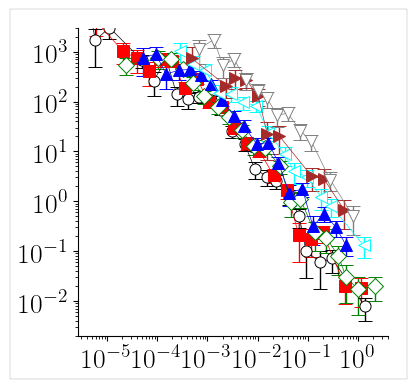

In [67]:
#--- density plots: rho(r) (paper version 2nd)


def returnCMtoInch(x,y):
    return (x/2.54,y/2.54)

fig, ax = plt.subplots(figsize=(4,4))
#---
ax.spines['right'].set_visible(False) #--- half open
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#---
ax.axis([4/(3e3/2e-3),4,2e-3,3e3])
ax.loglog()

#--- add major xticks
xmin=np.ceil(np.log10(ax.axis()[0]))
xmax=np.floor(np.log10(ax.axis()[1]))
nbin = xmax - xmin
ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))

#--- add major yticks
ymin=np.ceil(np.log10(ax.axis()[2]))
ymax=np.floor(np.log10(ax.axis()[3]))
nbin = ymax - ymin
ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))

#--- put minor bins
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#--- put minor bins y
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#plt.xlabel(r'$R=r/10^{%s m}$'%alpha)
#plt.ylabel(r'$P(R)=P(r)\times 10^{%s m}$'%alpha)
#plt.xlim(1e-5,1e0)
#plt.ylim(1e-5,1e0)

#colors = ['black','red','green','blue','cyan']
#fillstyles=['white',None,'white',None,'white',None]
#markers=['o','s','D','^','<']
for key,col,mk,fl in zip(X,colors,markers,fillstyles):
    ax.errorbar(X[key],
                 rho_dict[key],
                 yerr=Err[key],
                 label='%2.1f-%2.1f'%(m_range[key][0],m_range[key][1]),
                 fmt='-o', markersize=8,color=col,marker=mk,markerfacecolor=fl,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1
                )

    #fig.legend(title='m',prop=fontP,loc='lower left',frameon=False)#, bbox_to_anchor=(0.4, .6))
#ax.tick_params(axis='y',left=True, right=True,which='both')
#ax.tick_params(axis='x',bottom=True, top=True,which='both')
DrawFrame(ax, (0.22,0.06),(0.14,0.06),0.1,LOG_X=True,LOG_Y=True)


#plt.tight_layout()
plt.savefig('%s/rho_t.png'%DIR_OUTPT_figs,dpi=300,bbox_inches='tight',transparent=True)
